#1. Imports

In [ ]:
# === Instalasi Library Tambahan ===
!pip install catboost -q

In [ ]:
# === Sistem Operasi & Drive ===
import os
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Compfest Bebek Ngapak/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === Library Data Manipulasi dan Analisis ===
import pandas as pd
import numpy as np

# === Visualisasi Data ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# === Statistik dan Korelasi ===
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === Scikit-learn untuk ML ===
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import clone

# === Model Gradient Boosting Eksternal ===
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# === Miscellaneous ===
import calendar
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading

In [ ]:
# Load CSV file dari Google Drive
train_path = os.path.join(base_path, 'train.csv')
test_path = os.path.join(base_path, 'test.csv')
if os.path.exists(train_path):
    df_train = pd.read_csv(train_path)
else:
    raise FileNotFoundError("Train file not found!")

if os.path.exists(test_path):
    df_test = pd.read_csv(test_path)
else:
    raise FileNotFoundError("Test file not found!")

# 3. Exploratory Data Analysis (EDA)

In [ ]:
df_train.head()

,ID,date,cluster_id,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,cluster_1_2014-01-01,2014-01-01,cluster_1,358.032,10.8,4.2,5.5,0.4,53.003333,29787.533333,40.6,79.2,186.000000,1.176667,0.483333
1,cluster_2_2014-01-01,2014-01-01,cluster_2,548.247,12.2,4.3,8.6,-0.4,8195.656667,30650.350000,36.0,81.7,170.591118,3.383333,0.736667
2,cluster_3_2014-01-01,2014-01-01,cluster_3,758.303,12.9,-0.8,10.1,-4.9,16305.260000,31547.686667,20.9,44.3,159.467752,3.880000,0.716667
3,cluster_4_2014-01-01,2014-01-01,cluster_4,1072.077,10.8,4.7,6.7,0.6,9224.803333,30769.220000,34.7,82.8,184.339753,3.153333,0.676667
4,cluster_1_2014-01-02,2014-01-02,cluster_1,386.908,10.7,7.0,6.6,3.3,22372.000000,29850.226667,34.3,75.2,210.333465,3.640000,0.780000


In [ ]:
df_train.tail()

,ID,date,cluster_id,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
11683,cluster_4_2021-12-30,2021-12-30,cluster_4,994.158,14.9,7.7,15.6,6.2,16136.066667,30666.253333,22.8,42.8,263.384394,3.563333,0.590000
11684,cluster_1_2021-12-31,2021-12-31,cluster_1,354.565,14.7,7.7,13.4,5.2,19148.153333,29727.200000,20.7,37.4,201.332279,3.510000,0.513333
11685,cluster_2_2021-12-31,2021-12-31,cluster_2,507.510,16.2,7.0,16.3,4.5,20570.920000,30594.280000,23.3,40.7,186.250597,5.006667,0.733333
11686,cluster_3_2021-12-31,2021-12-31,cluster_3,705.999,15.9,5.9,15.9,3.2,26860.350000,31496.173333,15.1,27.7,196.223902,5.783333,0.720000
11687,cluster_4_2021-12-31,2021-12-31,cluster_4,992.349,14.6,5.5,13.3,3.3,23063.000000,30713.893333,16.4,28.8,192.980343,4.816667,0.560000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           11688 non-null  object 
 1   date                         11688 non-null  object 
 2   cluster_id                   11688 non-null  object 
 3   electricity_consumption      11688 non-null  float64
 4   temperature_2m_max           11688 non-null  float64
 5   temperature_2m_min           11688 non-null  float64
 6   apparent_temperature_max     11688 non-null  float64
 7   apparent_temperature_min     11688 non-null  float64
 8   sunshine_duration            11688 non-null  float64
 9   daylight_duration            11688 non-null  float64
 10  wind_speed_10m_max           11688 non-null  float64
 11  wind_gusts_10m_max           11688 non-null  float64
 12  wind_direction_10m_dominant  11688 non-null  float64
 13  shortwave_radiat

In [ ]:
df_train.describe()

,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
count,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000
mean,642.313328,18.733385,7.174786,17.215315,4.784608,29302.656241,44070.779592,23.273058,46.420115,202.335554,12.742257,2.428585
std,287.673473,7.504161,5.960263,9.085303,7.260336,13600.113712,9283.839471,7.993389,15.226372,100.697741,7.588077,1.607845
min,207.472000,-1.900000,-10.800000,-8.100000,-15.400000,0.000000,29447.550000,6.800000,13.300000,0.002855,0.333333,0.173333
25%,414.376000,12.800000,2.500000,10.000000,-1.100000,19104.170833,35150.501667,17.400000,35.300000,134.384708,5.600000,0.990000
50%,602.672000,18.200000,7.100000,16.400000,4.400000,29917.360000,44185.056667,22.000000,43.900000,219.000000,12.140000,2.156667
75%,836.034500,24.300000,12.100000,24.000000,10.800000,40697.756667,52997.815833,28.000000,54.700000,281.609519,18.924167,3.616667
max,1658.348000,40.900000,23.200000,42.600000,23.800000,53498.910000,58501.420000,63.900000,126.700000,360.000000,29.983333,8.133333


In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d')

In [ ]:
df_train['cluster_id'] = df_train['cluster_id'].str.replace('cluster_', '').astype(int)
df_test['cluster_id'] = df_test['cluster_id'].str.replace('cluster_', '').astype(int)

In [ ]:
def add_basic_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    return df

df_train = add_basic_date_features(df_train)
df_test = add_basic_date_features(df_test)

## 3.1 Rata-rata Konsumsi Listrik Bulanan per Tahun

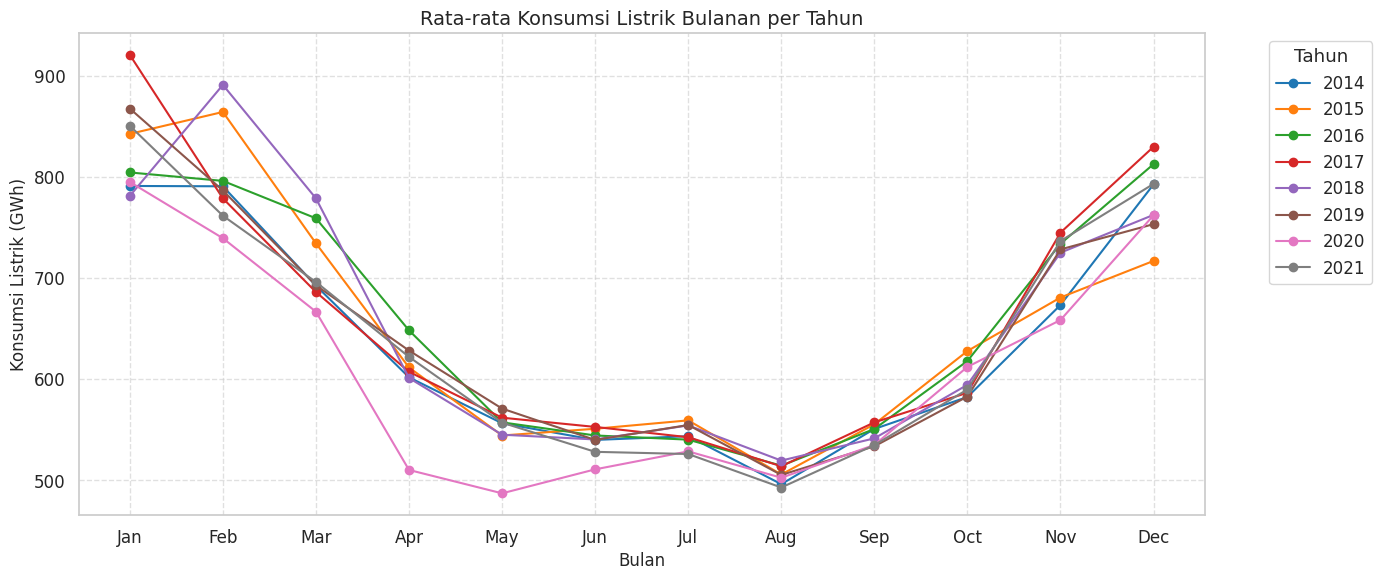

In [ ]:
monthly_consumption = (
    df_train.groupby(['year', 'month'])['electricity_consumption']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))

colors = sns.color_palette("tab10", n_colors=monthly_consumption['year'].nunique())

for idx, year in enumerate(sorted(monthly_consumption['year'].unique())):
    data_per_year = monthly_consumption[monthly_consumption['year'] == year]
    plt.plot(
        data_per_year['month'],
        data_per_year['electricity_consumption'],
        marker='o',
        label=str(year),
        color=colors[idx]
    )

plt.title('Rata-rata Konsumsi Listrik Bulanan per Tahun', fontsize=14)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Konsumsi Listrik (GWh)', fontsize=12)
plt.xticks(range(1, 13), labels=calendar.month_abbr[1:], rotation=0)
plt.legend(title='Tahun', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 3.2 Analisis Tren Musiman Fitur Cuaca

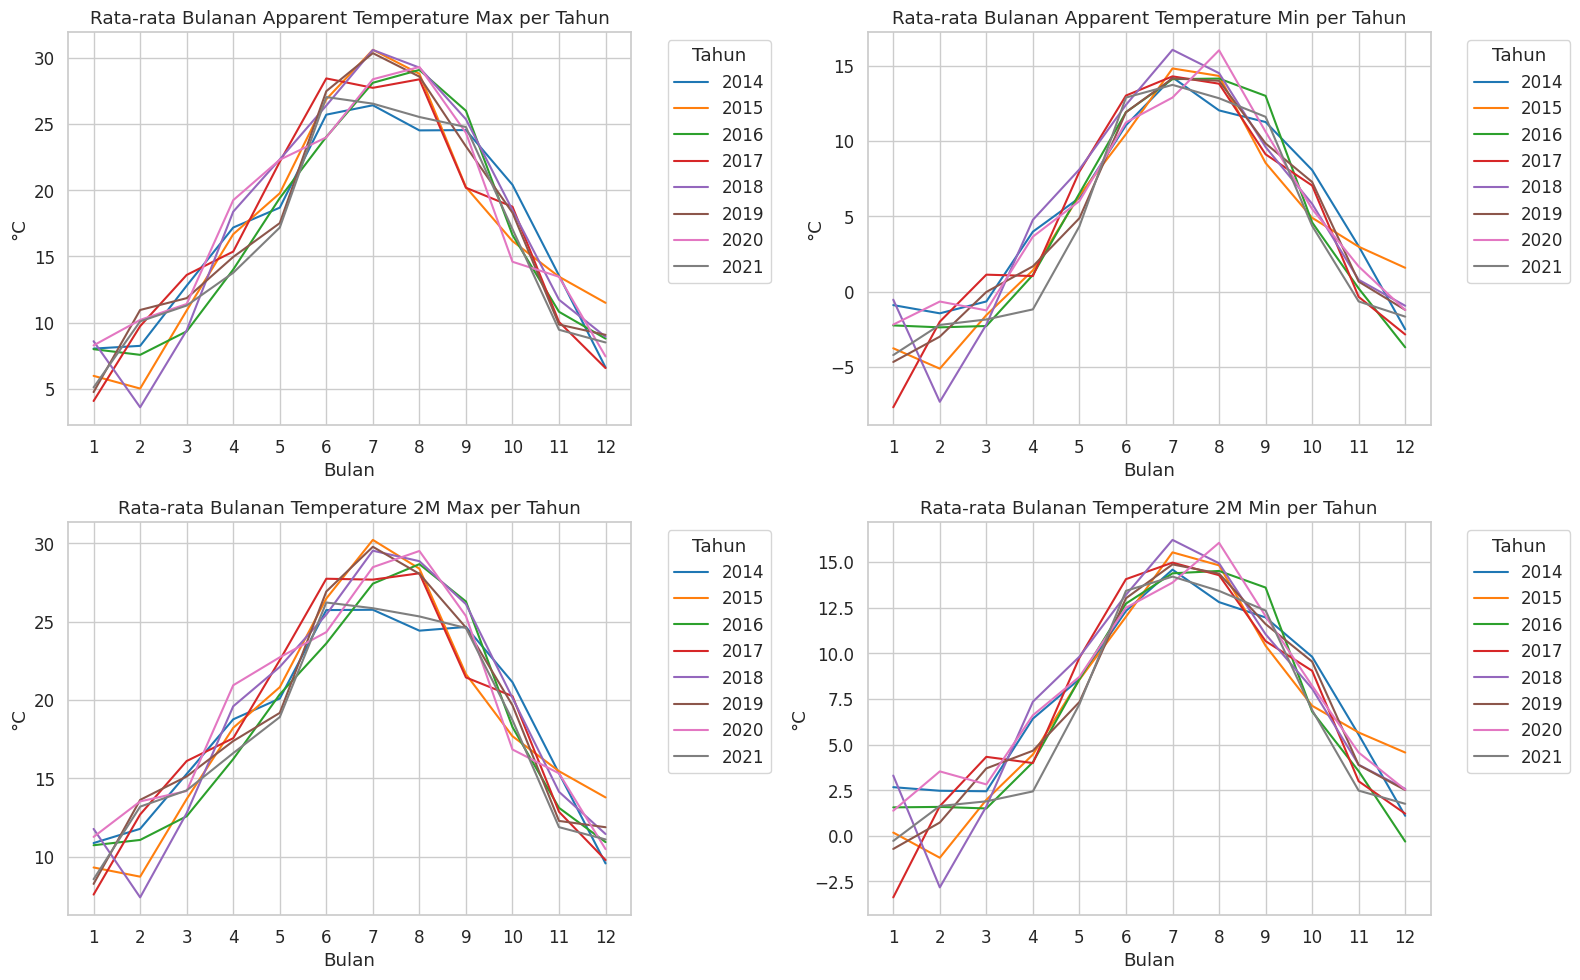

In [ ]:
temp_features = [
    'apparent_temperature_max',
    'apparent_temperature_min',
    'temperature_2m_max',
    'temperature_2m_min'
]

monthly_temp = (
    df_train
    .groupby(['year', 'month'])[temp_features]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(temp_features):
    ax = axes[i]
    sns.lineplot(
        x='month',
        y=feature,
        hue='year',
        data=monthly_temp,
        palette='tab10',
        ax=ax
    )
    ax.set_title(f'Rata-rata Bulanan {feature.replace("_", " ").title()} per Tahun')
    ax.set_xlabel('Bulan')
    ax.set_ylabel('°C')
    ax.set_xticks(range(1, 13))
    ax.legend(title='Tahun', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 3.3 Analisis Cluster

In [ ]:
avg_consumption_cluster = (
    df_train
    .groupby('cluster_id', as_index=False)['electricity_consumption']
    .mean()
    .rename(columns={'electricity_consumption': 'avg_electricity_consumption'})
)

min_avg = avg_consumption_cluster['avg_electricity_consumption'].min()
max_avg = avg_consumption_cluster['avg_electricity_consumption'].max()

avg_consumption_cluster['ratio_to_min'] = avg_consumption_cluster['avg_electricity_consumption'] / min_avg

overall_ratio = max_avg / min_avg

print(f'Rasio cluster max/min: {overall_ratio:.2f}')
avg_consumption_cluster

Rasio cluster max/min: 2.99


,cluster_id,avg_electricity_consumption,ratio_to_min
0,1,340.734297,1.000000
1,2,503.367172,1.477301
2,3,706.762751,2.074234
3,4,1018.389092,2.988807


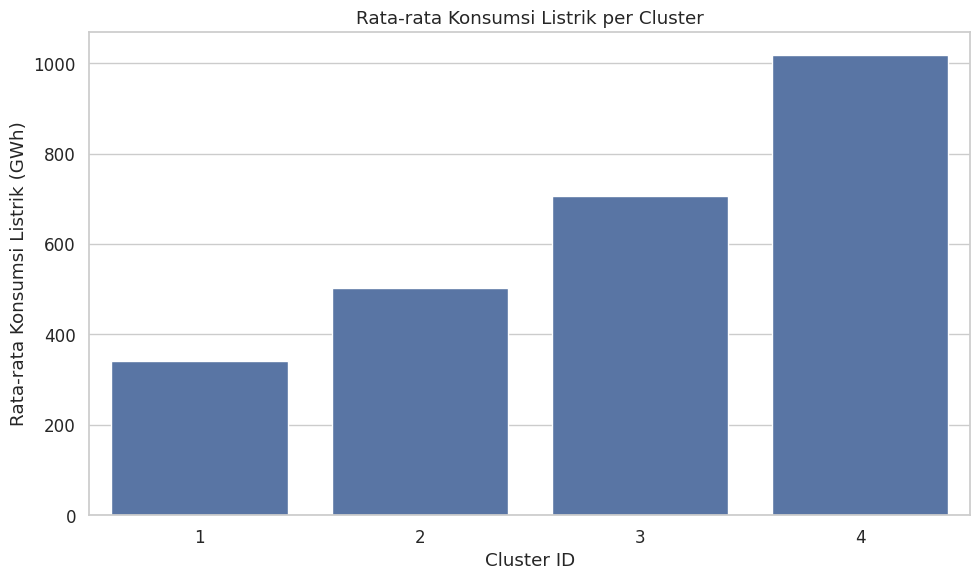

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_consumption_cluster,
    x='cluster_id',
    y='avg_electricity_consumption'
)
plt.title("Rata-rata Konsumsi Listrik per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Rata-rata Konsumsi Listrik (GWh)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3.4 Analisis Attributes Cuaca

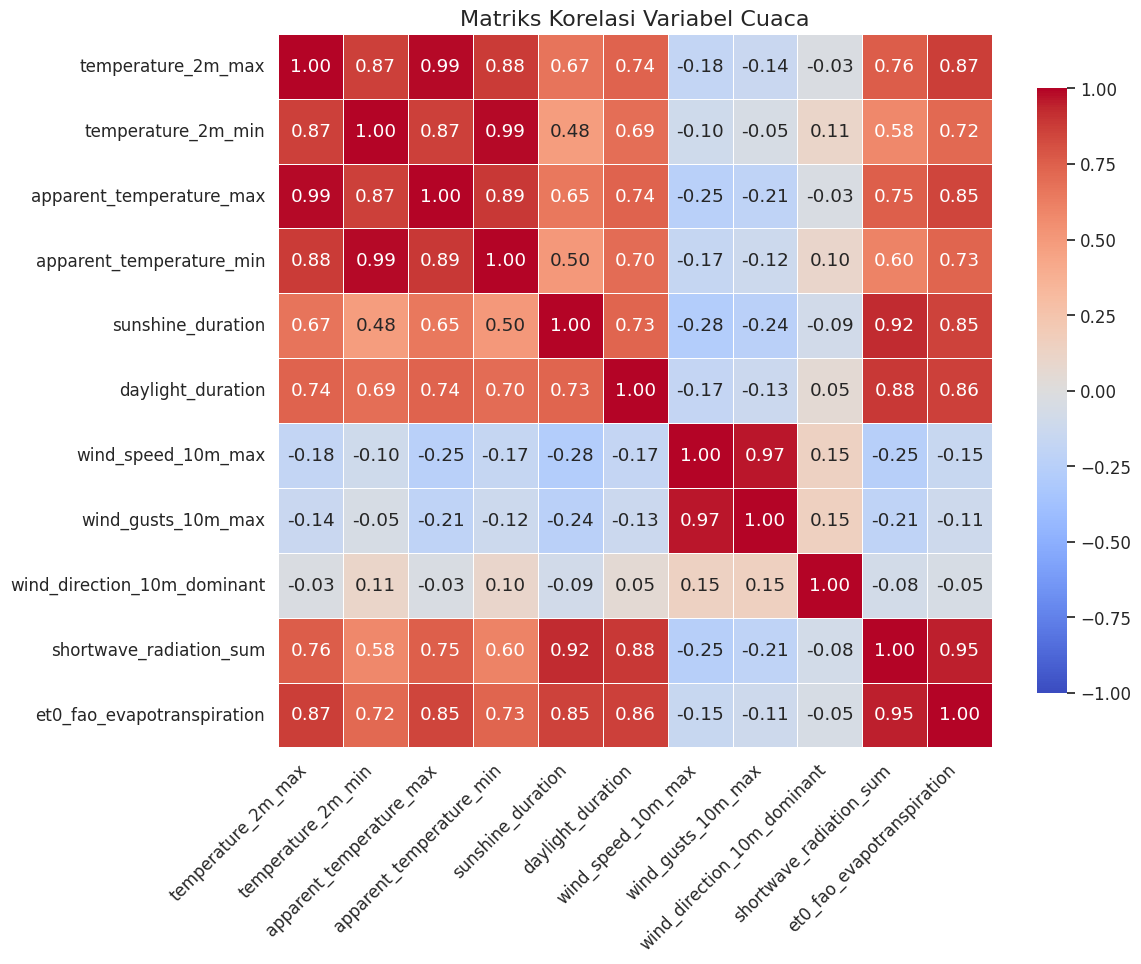

In [ ]:
cuaca_cols = [
    'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
    'apparent_temperature_min', 'sunshine_duration', 'daylight_duration',
    'wind_speed_10m_max', 'wind_gusts_10m_max',
    'wind_direction_10m_dominant', 'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

corr_matrix = df_train[cuaca_cols].corr(method='pearson')

sns.set(style='whitegrid', font_scale=1.1)

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Matriks Korelasi Variabel Cuaca", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def get_high_corr_pairs(corr_matrix, threshold=0.9):
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    corr_pairs = (
        corr_matrix.where(mask)
        .stack()
        .reset_index()
        .rename(columns={0: 'Correlation', 'level_0': 'Variable_1', 'level_1': 'Variable_2'})
    )

    high_corr = corr_pairs.loc[corr_pairs['Correlation'].abs() > threshold]
    high_corr = high_corr.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return high_corr

high_corr_pairs = get_high_corr_pairs(corr_matrix, threshold=0.9)

print(f"Pasangan variabel dengan |r| > 0.9 (n={len(high_corr_pairs)}):")
display(high_corr_pairs)

Pasangan variabel dengan |r| > 0.9 (n=5):


,Variable_1,Variable_2,Correlation
0,temperature_2m_min,apparent_temperature_min,0.990199
1,temperature_2m_max,apparent_temperature_max,0.989144
2,wind_speed_10m_max,wind_gusts_10m_max,0.965132
3,shortwave_radiation_sum,et0_fao_evapotranspiration,0.953101
4,sunshine_duration,shortwave_radiation_sum,0.923204


In [ ]:
weather_data = df_train[cuaca_cols].dropna().reset_index(drop=True)

vif_data = pd.DataFrame({
    'Feature': weather_data.columns,
    'VIF': [variance_inflation_factor(weather_data.values, i) for i in range(weather_data.shape[1])]
})

vif_data = vif_data.sort_values(by='VIF', ascending=True, ignore_index=True)

print(f"VIF (Variance Inflation Factor) untuk {len(weather_data.columns)} fitur:")
display(vif_data)

VIF (Variance Inflation Factor) untuk 11 fitur:


,Feature,VIF
0,wind_direction_10m_dominant,5.741745
1,sunshine_duration,44.605247
2,daylight_duration,92.450332
3,apparent_temperature_min,98.605546
4,et0_fao_evapotranspiration,108.593113
5,wind_speed_10m_max,149.873803
6,wind_gusts_10m_max,157.607938
7,temperature_2m_min,167.861953
8,shortwave_radiation_sum,184.458171
9,apparent_temperature_max,294.713339


## 3.5 Analisis Konsumsi Rata-rata saat Suhu Minimum & Durasi Sinar Matahari rendah

In [ ]:
temp_p25 = df_train['temperature_2m_min'].quantile(0.25)

sunshine_mean = df_train['sunshine_duration'].mean()

filtered = df_train[
    (df_train['temperature_2m_min'] < temp_p25) &
    (df_train['sunshine_duration'] < sunshine_mean)
]

result = filtered.groupby('cluster_id')['electricity_consumption'].mean().reset_index()
result = result.rename(columns={'electricity_consumption': 'avg_electricity_lowtemp_lowsun'})

overall = df_train.groupby('cluster_id')['electricity_consumption'].mean().reset_index()
overall = overall.rename(columns={'electricity_consumption': 'overall_avg_electricity'})

comparison = pd.merge(result, overall, on='cluster_id')
comparison['diff'] = comparison['avg_electricity_lowtemp_lowsun'] - comparison['overall_avg_electricity']

comparison = comparison.sort_values(by='diff', ascending=False).reset_index(drop=True)
comparison

,cluster_id,avg_electricity_lowtemp_lowsun,overall_avg_electricity,diff
0,4,1290.826150,1018.389092,272.437058
1,3,887.137849,706.762751,180.375098
2,2,656.699589,503.367172,153.332416
3,1,446.717842,340.734297,105.983545


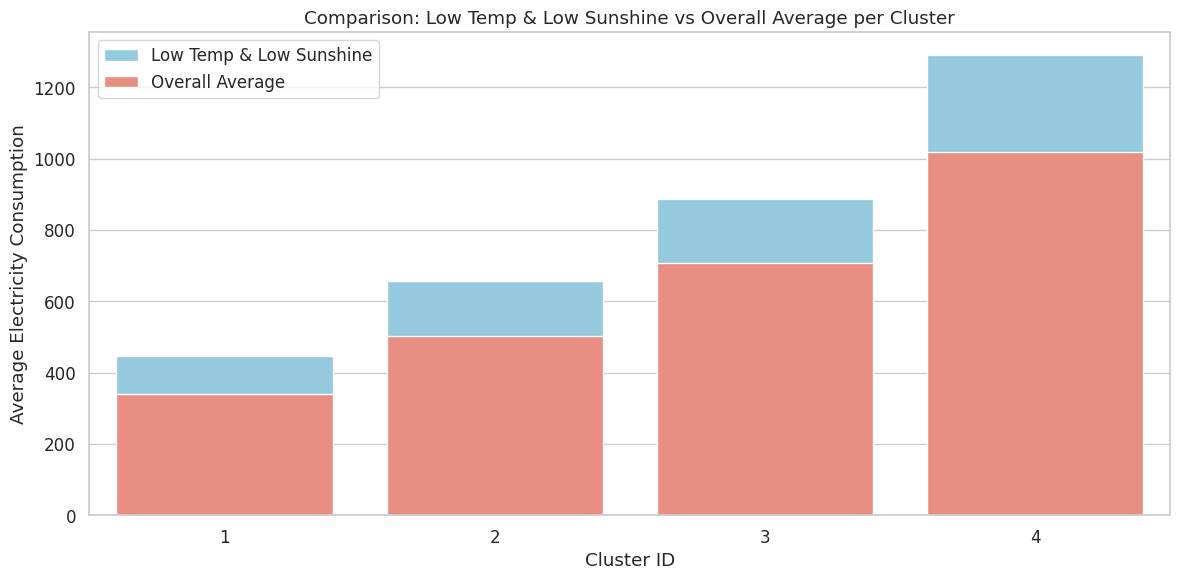

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x='cluster_id',
    y='avg_electricity_lowtemp_lowsun',
    data=comparison,
    color='skyblue',
    label='Low Temp & Low Sunshine'
)

sns.barplot(
    x='cluster_id',
    y='overall_avg_electricity',
    data=comparison,
    color='salmon',
    label='Overall Average'
)

plt.xlabel('Cluster ID')
plt.ylabel('Average Electricity Consumption')
plt.title('Comparison: Low Temp & Low Sunshine vs Overall Average per Cluster')
plt.legend()
plt.tight_layout()
plt.show()

## 3.6 Visualisasi Distribusi Target

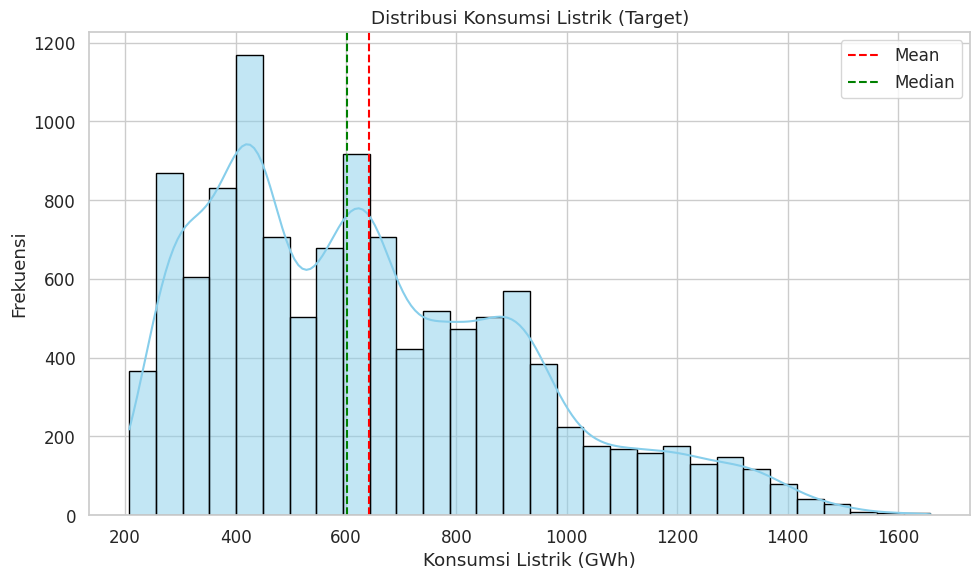

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['electricity_consumption'], kde=True, bins=30, color='skyblue', edgecolor='black')
plt.axvline(df_train['electricity_consumption'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df_train['electricity_consumption'].median(), color='green', linestyle='--', label='Median')
plt.title('Distribusi Konsumsi Listrik (Target)')
plt.xlabel('Konsumsi Listrik (GWh)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 3.7 Boxplot Target & Fitur Cuaca

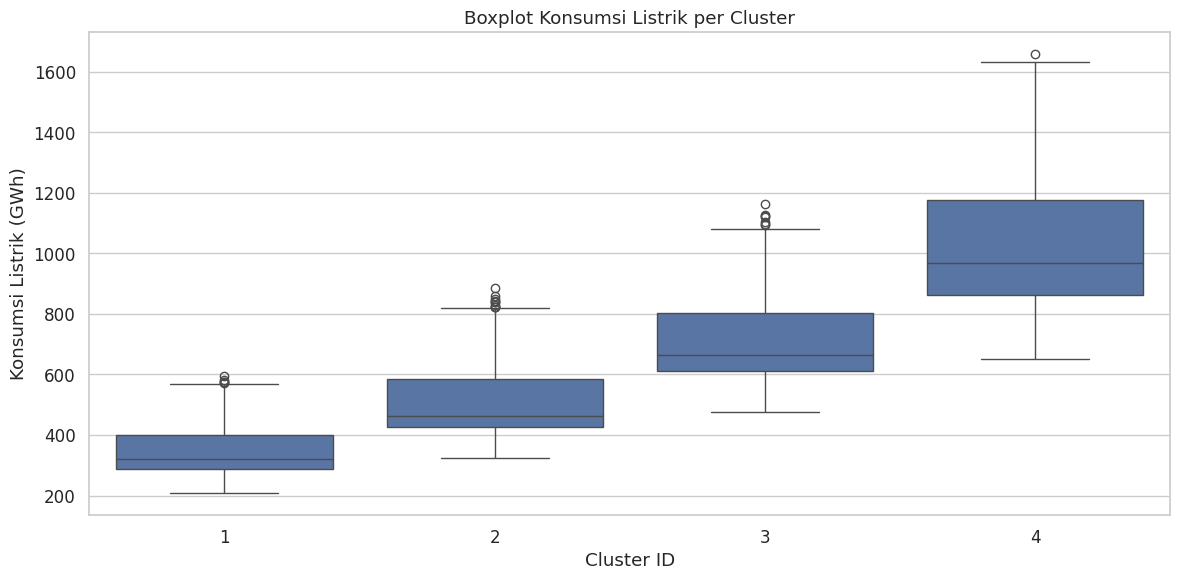

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_id', y='electricity_consumption', data=df_train)
plt.title('Boxplot Konsumsi Listrik per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Konsumsi Listrik (GWh)')
plt.tight_layout()
plt.show()

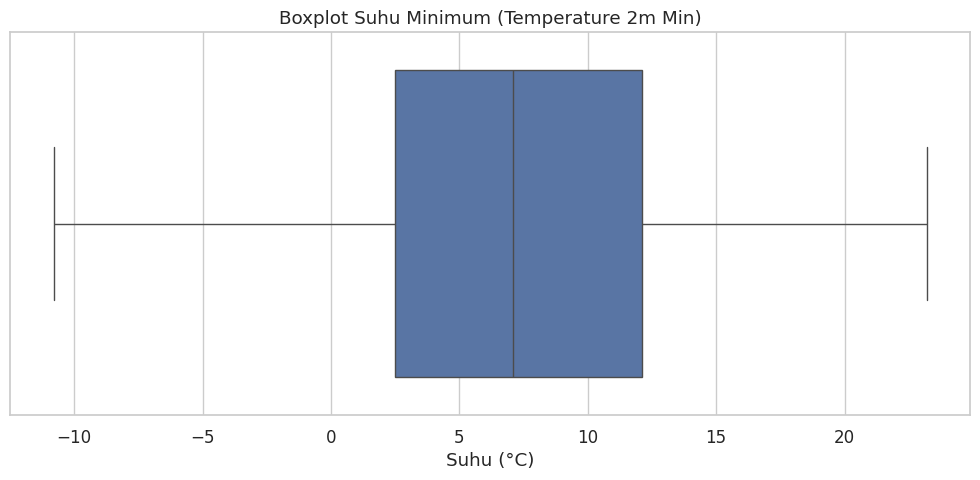

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_train['temperature_2m_min'])
plt.title('Boxplot Suhu Minimum (Temperature 2m Min)')
plt.xlabel('Suhu (°C)')
plt.tight_layout()
plt.show()

## 3.8 Korelasi Terhadap Target

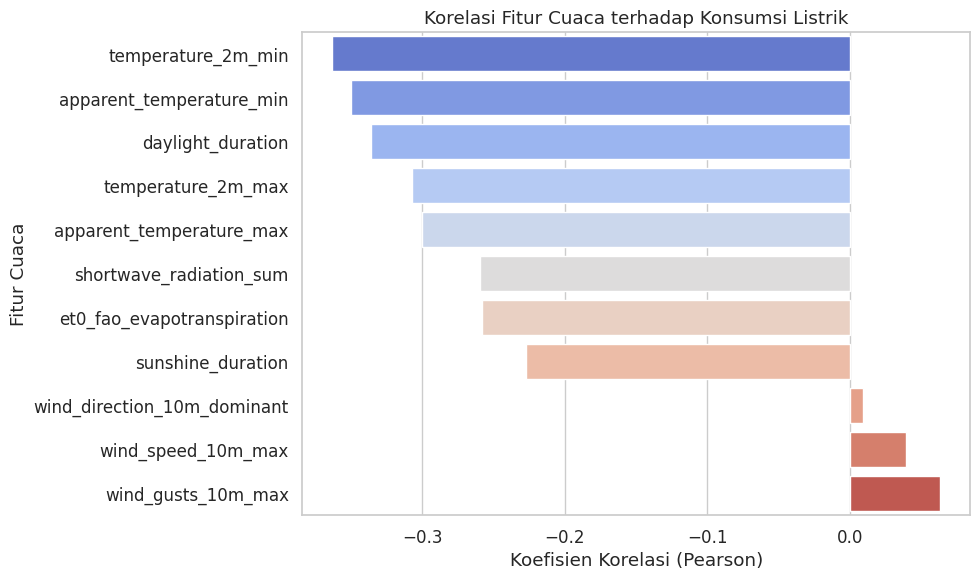

In [ ]:
target_corr = df_train[cuaca_cols + ['electricity_consumption']].corr()['electricity_consumption'].drop('electricity_consumption')
target_corr = target_corr.sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title("Korelasi Fitur Cuaca terhadap Konsumsi Listrik")
plt.xlabel("Koefisien Korelasi (Pearson)")
plt.ylabel("Fitur Cuaca")
plt.tight_layout()
plt.show()

## 3.9 Plot Trend Konsumsi Listrik Agregat

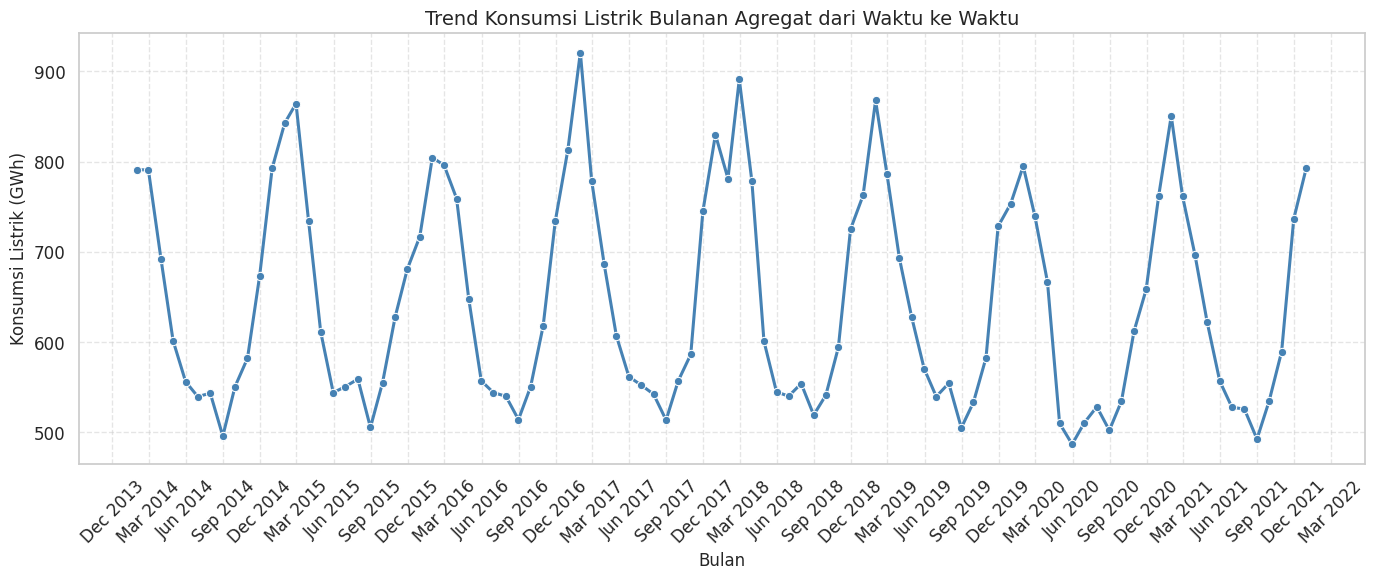

In [ ]:
monthly_avg = (
    df_train
    .groupby(pd.Grouper(key='date', freq='M'))['electricity_consumption']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=monthly_avg,
    x='date',
    y='electricity_consumption',
    marker='o',
    linewidth=2.2,
    color='steelblue'
)

plt.title("Trend Konsumsi Listrik Bulanan Agregat dari Waktu ke Waktu", fontsize=14)
plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Konsumsi Listrik (GWh)", fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 3.10 Visualisasi Heatmap Konsumsi Listrik Bulanan per Cluster

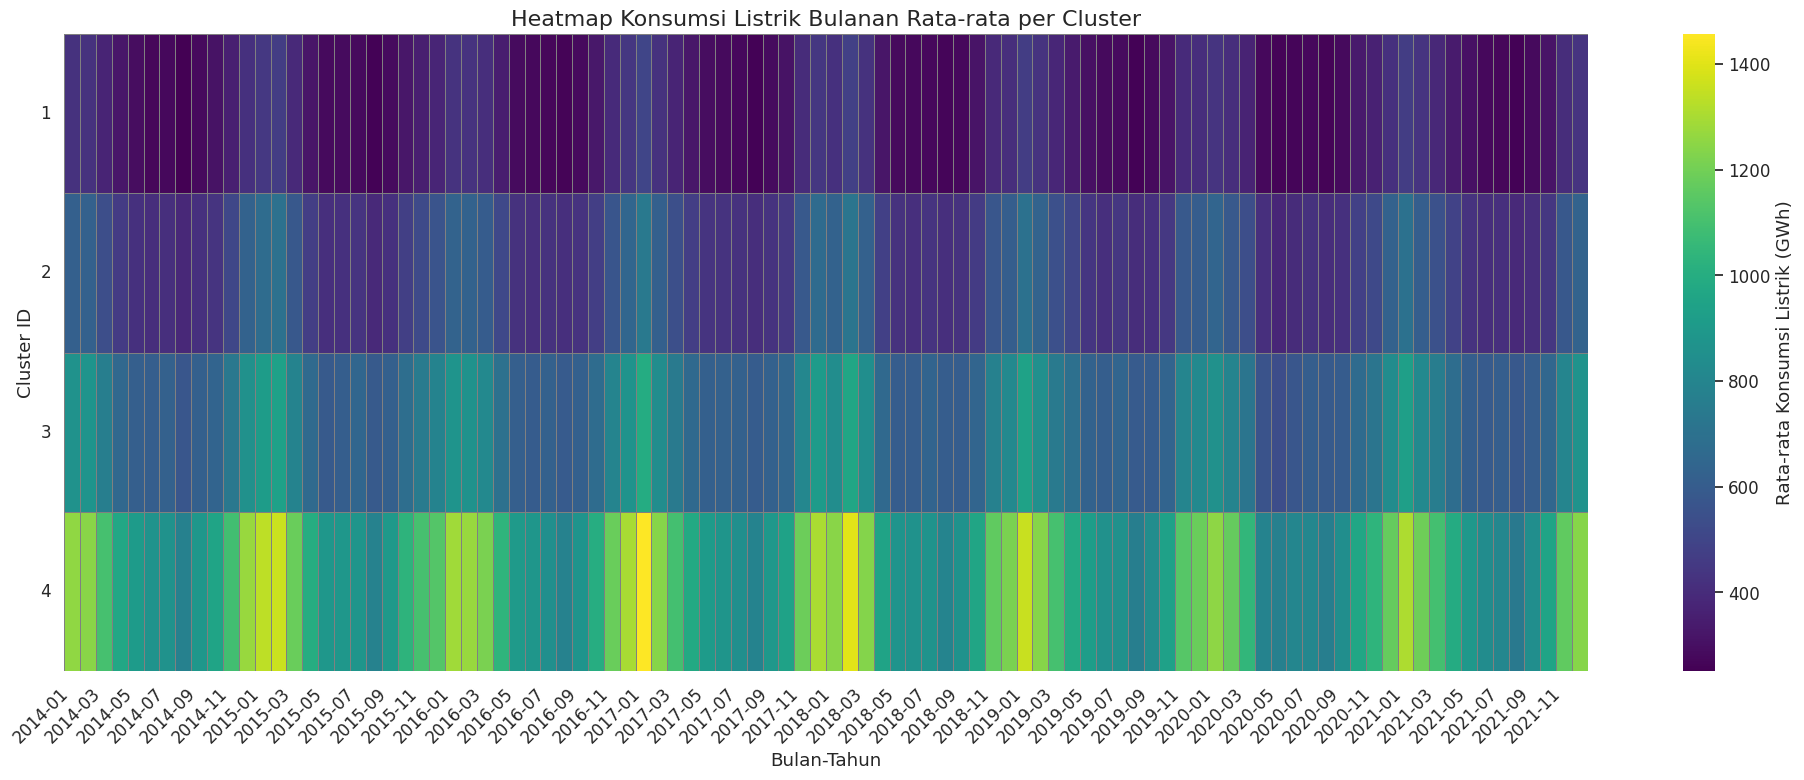

In [ ]:
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# Hitung rata-rata konsumsi listrik bulanan per cluster
df_monthly = (
    df_train.groupby(['cluster_id', 'year_month'])['electricity_consumption']
    .mean()
    .reset_index()
)

# Pivot data agar year_month jadi kolom dan cluster jadi baris
pivot = df_monthly.pivot(
    index='cluster_id',
    columns='year_month',
    values='electricity_consumption'
)

# Urutkan kolom tanggal secara kronologis
pivot = pivot.sort_index(axis=1)

plt.figure(figsize=(20, 8))
sns.heatmap(
    pivot,
    cmap='viridis',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Rata-rata Konsumsi Listrik (GWh)'},
    square=False
)

plt.title('Heatmap Konsumsi Listrik Bulanan Rata-rata per Cluster', fontsize=16)
plt.xlabel('Bulan-Tahun')
plt.ylabel('Cluster ID')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 4. Feature Engineering

In [ ]:
def create_features(df):
    """Create features for electricity consumption prediction"""
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['cluster_id', 'date']).reset_index(drop=True)

    def add_temporal_features(df):
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['dayofweek'] = df['date'].dt.dayofweek
        df['dayofyear'] = df['date'].dt.dayofyear
        df['quarter'] = df['date'].dt.quarter
        df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
        df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
        df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
        return df

    def add_cyclical_encoding(df):
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
        df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
        df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
        df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
        return df

    def add_temperature_features(df):
        df['temp_range'] = df['temperature_2m_max'] - df['temperature_2m_min']
        df['temp_mean'] = (df['temperature_2m_max'] + df['temperature_2m_min']) / 2
        df['apparent_temp_range'] = df['apparent_temperature_max'] - df['apparent_temperature_min']
        df['apparent_temp_mean'] = (df['apparent_temperature_max'] + df['apparent_temperature_min']) / 2
        df['heating_degree_days'] = np.maximum(18 - df['temp_mean'], 0)
        df['cooling_degree_days'] = np.maximum(df['temp_mean'] - 22, 0)
        df['total_energy_demand'] = df['heating_degree_days'] + df['cooling_degree_days']
        df['temp_mean_squared'] = df['temp_mean'] ** 2
        df['temp_mean_cubed'] = df['temp_mean'] ** 3
        df['heating_squared'] = df['heating_degree_days'] ** 2
        df['cooling_squared'] = df['cooling_degree_days'] ** 2
        return df

    def add_temperature_zones(df):
        df['extreme_cold'] = (df['temp_mean'] < 0).astype(int)
        df['cold'] = ((df['temp_mean'] >= 0) & (df['temp_mean'] < 10)).astype(int)
        df['mild'] = ((df['temp_mean'] >= 10) & (df['temp_mean'] < 20)).astype(int)
        df['warm'] = ((df['temp_mean'] >= 20) & (df['temp_mean'] < 30)).astype(int)
        df['hot'] = (df['temp_mean'] >= 30).astype(int)
        return df

    def add_seasonal_anomaly(df):
        monthly_temp_mean = df.groupby('month')['temp_mean'].transform('mean')
        df['temp_deviation_from_seasonal'] = df['temp_mean'] - monthly_temp_mean
        df['temp_seasonal_anomaly'] = np.abs(df['temp_deviation_from_seasonal'])
        return df

    def add_cluster_features(df):
        dummies = pd.get_dummies(df['cluster_id'], prefix='cluster')
        df = pd.concat([df, dummies], axis=1)

        for cid in df['cluster_id'].unique():
            mask = df['cluster_id'] == cid
            df[f'{cid}_temp'] = 0.0
            df[f'{cid}_heating'] = 0.0
            df[f'{cid}_cooling'] = 0.0
            df[f'{cid}_temp_squared'] = 0.0

            df.loc[mask, f'{cid}_temp'] = df.loc[mask, 'temp_mean']
            df.loc[mask, f'{cid}_heating'] = df.loc[mask, 'heating_degree_days']
            df.loc[mask, f'{cid}_cooling'] = df.loc[mask, 'cooling_degree_days']
            df.loc[mask, f'{cid}_temp_squared'] = df.loc[mask, 'temp_mean_squared']
        return df

    def add_weather_features(df):
        df['wind_range'] = df['wind_gusts_10m_max'] - df['wind_speed_10m_max']
        df['wind_intensity'] = df['wind_speed_10m_max'] * df['wind_gusts_10m_max']
        df['wind_direction_sin'] = np.sin(np.radians(df['wind_direction_10m_dominant']))
        df['wind_direction_cos'] = np.cos(np.radians(df['wind_direction_10m_dominant']))
        return df

    def add_solar_features(df):
        df['sunshine_ratio'] = df['sunshine_duration'] / np.maximum(df['daylight_duration'], 1)
        df['sunshine_ratio'] = df['sunshine_ratio'].fillna(0)
        df['radiation_per_sunshine'] = df['shortwave_radiation_sum'] / np.maximum(df['sunshine_duration'], 1)
        df['cloud_cover_proxy'] = 1 - df['sunshine_ratio']
        return df

    def add_weather_interactions(df):
        df['temp_wind_interaction'] = df['temp_mean'] * df['wind_speed_10m_max']
        df['temp_solar_interaction'] = df['temp_mean'] * df['shortwave_radiation_sum']
        df['heating_wind_interaction'] = df['heating_degree_days'] * df['wind_speed_10m_max']
        return df

    def add_temporal_group_features(df):
        for cid in df['cluster_id'].unique():
            mask = df['cluster_id'] == cid
            sub = df[mask].copy()
            if len(sub) == 0:
                continue
            for window in [3, 7, 14, 30]:
                df.loc[mask, f'cluster_temp_ma_{window}'] = sub['temp_mean'].rolling(window, min_periods=1).mean().values
                df.loc[mask, f'cluster_heating_ma_{window}'] = sub['heating_degree_days'].rolling(window, min_periods=1).mean().values
                df.loc[mask, f'cluster_cooling_ma_{window}'] = sub['cooling_degree_days'].rolling(window, min_periods=1).mean().values

            for window in [7, 14, 30]:
                if len(sub) > window:
                    trend = sub['temp_mean'].rolling(window, min_periods=2).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
                    df.loc[mask, f'cluster_temp_trend_{window}'] = trend.fillna(0).values
            df.loc[mask, 'temp_volatility_7'] = sub['temp_mean'].rolling(7, min_periods=1).std().fillna(0).values
            df.loc[mask, 'temp_volatility_14'] = sub['temp_mean'].rolling(14, min_periods=1).std().fillna(0).values
            df.loc[mask, 'solar_volatility_7'] = sub['shortwave_radiation_sum'].rolling(7, min_periods=1).std().fillna(0).values
        return df

    def add_calendar_and_stress_features(df):
        df['working_day_intensity'] = 1.0
        df.loc[df['dayofweek'] == 5, 'working_day_intensity'] = 0.8
        df.loc[df['dayofweek'] == 6, 'working_day_intensity'] = 0.6
        df['day_of_month_sin'] = np.sin(2 * np.pi * df['day'] / 30)
        df['day_of_month_cos'] = np.cos(2 * np.pi * df['day'] / 30)
        df['week_of_year'] = df['date'].dt.isocalendar().week
        df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
        df['is_near_new_year'] = ((df['month'] == 1) & (df['day'] <= 7) | (df['month'] == 12) & (df['day'] >= 25)).astype(int)
        df['is_mid_month'] = ((df['day'] >= 10) & (df['day'] <= 20)).astype(int)
        df['extreme_heating_scenario'] = ((df['temp_mean'] < 5) & (df['wind_speed_10m_max'] > 30)).astype(int)
        df['extreme_cooling_scenario'] = ((df['temp_mean'] > 30) & (df['sunshine_duration'] > 40000)).astype(int)
        df['weather_stress_index'] = (df['heating_degree_days'] + df['cooling_degree_days']) * df['wind_intensity'] / 1000
        df['comfort_deviation'] = np.abs(df['temp_mean'] - 20) * (1 + df['wind_speed_10m_max'] / 50)
        winter = df['month'].isin([12, 1, 2])
        summer = df['month'].isin([6, 7, 8])
        df['seasonal_energy_pressure'] = 0.0
        df.loc[winter, 'seasonal_energy_pressure'] = df.loc[winter, 'heating_degree_days'] / 20
        df.loc[summer, 'seasonal_energy_pressure'] = df.loc[summer, 'cooling_degree_days'] / 10
        return df

    def fill_missing(df):
        for col in df.select_dtypes(include=[np.number]).columns:
            if df[col].isnull().any():
                df[col] = df[col].fillna(df[col].median())
        return df

    # Apply all components
    df = add_temporal_features(df)
    df = add_cyclical_encoding(df)
    df = add_temperature_features(df)
    df = add_temperature_zones(df)
    df = add_seasonal_anomaly(df)
    df = add_cluster_features(df)
    df = add_weather_features(df)
    df = add_solar_features(df)
    df = add_weather_interactions(df)
    df = add_temporal_group_features(df)
    df = add_calendar_and_stress_features(df)
    df = fill_missing(df)

    return df

## 4.1 Analisis Multicollinearity Fitur Baru

In [ ]:
df_new_features = create_features(df_train)

In [ ]:
cuaca_cols = [
    'temperature_2m_max', 'temperature_2m_min',
    'apparent_temperature_max', 'apparent_temperature_min',
    'sunshine_duration', 'daylight_duration',
    'wind_speed_10m_max', 'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]


time_cols = [
    'year', 'month', 'day', 'dayofweek', 'dayofyear',
    'quarter', 'is_weekend', 'is_month_start', 'is_month_end',
    'month_sin', 'month_cos',
    'day_sin', 'day_cos',
    'dayofweek_sin', 'dayofweek_cos',
    'dayofyear_sin', 'dayofyear_cos',
    'day_of_month_sin', 'day_of_month_cos',
    'week_of_year', 'week_sin', 'week_cos'
]

temp_cols = [
    'temp_mean', 'temp_range',
    'apparent_temp_mean', 'apparent_temp_range',
    'temp_mean_squared', 'temp_mean_cubed',
    'heating_degree_days', 'cooling_degree_days',
    'heating_squared', 'cooling_squared',
    'total_energy_demand'
]

temp_zone_cols = [
    'extreme_cold', 'cold', 'mild', 'warm', 'hot'
]

seasonal_cols = [
    'temp_deviation_from_seasonal',
    'temp_seasonal_anomaly'
]

wind_cols = [
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'wind_range',
    'wind_intensity',
    'wind_direction_sin',
    'wind_direction_cos'
]

solar_cols = [
    'sunshine_duration',
    'daylight_duration',
    'sunshine_ratio',
    'radiation_per_sunshine',
    'shortwave_radiation_sum',
    'cloud_cover_proxy'
]

weather_interaction_cols = [
    'temp_wind_interaction',
    'temp_solar_interaction',
    'heating_wind_interaction'
]

workday_cols = [
    'working_day_intensity',
    'is_near_new_year',
    'is_mid_month'
]

stress_cols = [
    'extreme_heating_scenario',
    'extreme_cooling_scenario',
    'weather_stress_index',
    'comfort_deviation',
    'seasonal_energy_pressure'
]

trend_vol_cols = [
    'temp_volatility_7', 'temp_volatility_14',
    'solar_volatility_7'
]


In [ ]:
def get_high_corr_pairs(df, feature_list, threshold=0.8):
    """
    Hitung korelasi dan kembalikan pasangan fitur dengan |r| di atas threshold.
    """
    corr_matrix = df[feature_list].corr(method='pearson')

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_pairs = (
        corr_matrix.where(mask)
        .stack()
        .reset_index()
        .rename(columns={0: 'Correlation', 'level_0': 'Variable_1', 'level_1': 'Variable_2'})
    )

    high_corr = corr_pairs.loc[corr_pairs['Correlation'].abs() > threshold]
    high_corr = high_corr.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return high_corr

In [ ]:
groups = {
    "Cuaca": cuaca_cols,
    "Time": time_cols,
    "Temperatur": temp_cols,
    "ZonaTemp": temp_zone_cols,
    "Musim": seasonal_cols,
    "Angin": wind_cols,
    "Surya": solar_cols,
    "Interaksi": weather_interaction_cols,
    "WorkingDay": workday_cols,
    "Stress": stress_cols,
    "Volatilitas": trend_vol_cols
}

all_high_corr = []

for name, cols in groups.items():
    high_corr = get_high_corr_pairs(df_new_features, cols, threshold=0.8)
    if not high_corr.empty:
        high_corr['Group'] = name
        all_high_corr.append(high_corr)

df_high_corr_all = pd.concat(all_high_corr, ignore_index=True)

print(f"Total pairs multikolinearitas terdeteksi: {len(df_high_corr_all)}")
df_high_corr_all


Total pairs multikolinearitas terdeteksi: 59


,Variable_1,Variable_2,Correlation,Group
0,temperature_2m_min,apparent_temperature_min,0.990199,Cuaca
1,temperature_2m_max,apparent_temperature_max,0.989144,Cuaca
2,wind_speed_10m_max,wind_gusts_10m_max,0.965132,Cuaca
3,shortwave_radiation_sum,et0_fao_evapotranspiration,0.953101,Cuaca
4,sunshine_duration,shortwave_radiation_sum,0.923204,Cuaca
5,apparent_temperature_max,apparent_temperature_min,0.887115,Cuaca
6,daylight_duration,shortwave_radiation_sum,0.883157,Cuaca
7,temperature_2m_max,apparent_temperature_min,0.882455,Cuaca
8,temperature_2m_max,et0_fao_evapotranspiration,0.868011,Cuaca
9,temperature_2m_min,apparent_temperature_max,0.866245,Cuaca


# 6. Prepare Model

In [ ]:
def train_stacking(X_train, y_train, X_test):
    """Train base models with OOF and stack with meta model"""
    models = {
        'catboost': cb.CatBoostRegressor(
            iterations=2000, learning_rate=0.03, depth=8, l2_leaf_reg=1,
            border_count=128, verbose=False, random_state=42
        ),
        'lightgbm': lgb.LGBMRegressor(
            objective='regression', metric='rmse',
            num_leaves=63, learning_rate=0.03, feature_fraction=0.8,
            bagging_fraction=0.7, bagging_freq=5, verbose=-1,
            random_state=42, n_estimators=2000, reg_alpha=0.1, reg_lambda=0.1
        ),
        'xgboost': xgb.XGBRegressor(
            objective='reg:squarederror', n_estimators=2000,
            max_depth=8, learning_rate=0.03, subsample=0.7,
            colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1,
            random_state=42, n_jobs=-1
        ),
        'random_forest': RandomForestRegressor(
            n_estimators=500, max_depth=20, min_samples_split=3,
            min_samples_leaf=1, random_state=42, n_jobs=-1
        ),
        'ridge': Ridge(alpha=5.0)
    }

    meta_model = Ridge(alpha=1.0)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    Z_train = np.zeros((X_train.shape[0], len(models)))
    Z_test = np.zeros((X_test.shape[0], len(models)))

    for idx, (name, model) in enumerate(models.items()):
        print(f"Training base model: {name}")
        oof_preds = np.zeros(X_train.shape[0])
        test_preds_folds = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            model_fold = clone(model)

            if name == 'ridge':
                model_fold.fit(X_train_scaled[train_idx], y_train.iloc[train_idx])
                oof_preds[val_idx] = model_fold.predict(X_train_scaled[val_idx])
                test_pred = model_fold.predict(X_test_scaled)
            else:
                model_fold.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
                oof_preds[val_idx] = model_fold.predict(X_train.iloc[val_idx])
                test_pred = model_fold.predict(X_test)

            test_preds_folds.append(test_pred)

        Z_train[:, idx] = oof_preds
        Z_test[:, idx] = np.mean(test_preds_folds, axis=0)

        rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
        print(f"  {name} OOF RMSE: {rmse:.4f}")

    print("\nTraining meta model on OOF matrix ...")

    # KFold CV for meta layer
    meta_oof = np.zeros(X_train.shape[0])
    for fold, (train_idx, val_idx) in enumerate(kf.split(Z_train)):
        meta_fold = clone(meta_model)
        meta_fold.fit(Z_train[train_idx], y_train.iloc[train_idx])
        meta_oof[val_idx] = meta_fold.predict(Z_train[val_idx])

    meta_rmse = np.sqrt(mean_squared_error(y_train, meta_oof))
    print(f"Meta model OOF RMSE: {meta_rmse:.4f}")

    # Fit final meta model on full Z_train
    meta_model.fit(Z_train, y_train)
    final_pred = meta_model.predict(Z_test)

    print("\nMeta model trained on OOF matrix — final prediction done.")
    return final_pred, Z_train, Z_test, meta_rmse

# 7. Training

In [ ]:
base_path = '/content/drive/MyDrive/Compfest Bebek Ngapak/data'
train_path = os.path.join(base_path, 'train.csv')
test_path = os.path.join(base_path, 'test.csv')
if os.path.exists(train_path):
    df_train = pd.read_csv(train_path)
else:
    raise FileNotFoundError("Train file not found!")

if os.path.exists(test_path):
    df_test = pd.read_csv(test_path)
else:
    raise FileNotFoundError("Test file not found!")

In [ ]:
def main_notebook_stacking(df_train, df_test):
    train_features = create_features(df_train)
    test_features = create_features(df_test)

    exclude_cols = ['ID', 'date', 'cluster_id', 'electricity_consumption']
    feature_cols = [col for col in train_features.columns if col not in exclude_cols]

    X_train = train_features[feature_cols]
    y_train = train_features['electricity_consumption']
    X_test = test_features[feature_cols]

    print(f"Training set shape : {X_train.shape}")
    print(f"Number of features : {len(feature_cols)}\n")

    final_pred, Z_train, Z_test, meta_rmse = train_stacking(X_train, y_train, X_test)

    submission = pd.DataFrame({
        'ID': test_features['ID'],
        'electricity_consumption': final_pred
    })
    submission.to_csv('submission_stacking.csv', index=False)

    print(f"\nMeta Model OOF RMSE: {meta_rmse:.4f}")
    print("Submission saved: submission_stacking.csv")

    return submission, Z_train, Z_test

submission, Z_train, Z_test = main_notebook_stacking(df_train, df_test)

Training set shape : (11688, 107)
Number of features : 107

Training base model: catboost
  catboost OOF RMSE: 15.8632
Training base model: lightgbm
  lightgbm OOF RMSE: 17.1993
Training base model: xgboost


# 8. Jawaban Soal Seleksi

## 1. Jawaban Pertanyaan Nomor 1
Dalam konteks bisnis energi dan kebijakan publik, apakah memprediksi konsumsi listrik harian merupakan hal yang mendesak? Jelaskan urgensinya dari perspektif grid management dan perencanaan kapasitas!

Ya, memprediksi konsumsi listrik harian merupakan hal yang sangat mendesak dalam konteks bisnis energi dan kebijakan publik. Hal ini berkaitan erat dengan tantangan pengelolaan sistem ketenagalistrikan modern, khususnya dalam aspek grid management dan perencanaan kapasitas.

a. Urgensi dari Perspektif Grid Management
Dalam operasional sistem tenaga listrik, prediksi konsumsi listrik harian sangat penting untuk mendukung:
- Keseimbangan Pasokan dan Permintaan Secara Real-Time Prediksi yang akurat akan dapat membantu operator sistem (PLN) menjaga keseimbangan antara suplai dan permintaan listrik setiap harinya. Ketidakseimbangan dapat menyebabkan pemadaman listrik (blackout) atau kelebihan suplai yang boros biaya. [1]
- Pengelolaan Spinning Reserve
Spinning reserve adalah kapasitas cadangan yang dapat digunakan saat terjadi lonjakan permintaan mendadak atau gangguan pembangkit. Prediksi yang baik memungkinkan operator sistem mengoptimalkan besaran spinning reserve sehingga tetap aman tanpa pemborosan. [1]
- Efisiensi dan Keandalan Operasi Smart Grid
Smart grid membutuhkan data prediksi konsumsi listrik untuk menjalankan algoritma optimasi, memanfaatkan energi terbarukan secara maksimal, serta mendeteksi dan memulihkan gangguan lebih cepat. Ini mengurangi risiko pemadaman listrik besar-besaran. [1][2][3]

b. Urgensi dari Perspektif Perencanaan Kapasitas
- Mengoptimalkan Investasi Infrastruktur Energi
Dengan prediksi konsumsi harian, perusahaan listrik dapat menyusun perencanaan jangka pendek dan jangka panjang terkait kebutuhan kapasitas pembangkit, transmisi, dan distribusi. Ini menghindari pembangunan kapasitas yang berlebihan (overcapacity) atau kekurangan kapasitas (undercapacity). [3]
- Menurunkan Biaya Operasional dan Tarif Konsumen
Prediksi konsumsi yang akurat berkontribusi pada efisiensi penggunaan pembangkit, sehingga biaya operasi dapat ditekan. Ini juga berdampak pada pengendalian tarif listrik bagi konsumen. [2], [4]
- Peningkatan Integrasi Energi Terbarukan
Salah satu target strategis pemerintah Indonesia adalah meningkatkan bauran energi terbarukan hingga 75% pada 2040. Energi terbarukan seperti PLTS dan PLTB bersifat fluktuatif, sehingga prediksi konsumsi menjadi landasan penting agar integrasi energi terbarukan tetap stabil dan dapat memenuhi kebutuhan masyarakat. [2], [3]

c. Relevansi dengan Kondisi Indonesia

Menurut Badan Pusat Statistik (BPS) data distribusi listrik nasional menunjukkan tren peningkatan konsumsi dari tahun ke tahun (2019–2023), baik untuk rumah tangga maupun industri. Di sisi lain, biaya operasional perusahaan listrik terus meningkat. Prediksi konsumsi listrik harian menjadi kunci untuk mengefisienkan operasi dan menjaga agar pendapatan dapat menutupi biaya dengan baik[5]. Selain itu, smart grid juga menjadi strategi utama untuk mendukung agenda nasional menuju kemandirian energi dan pengurangan emisi karbon. [3]


## 2. Jawaban Pertanyaan Nomor 2
Apakah model prediksi konsumsi listrik Anda mengalami overfit atau underfit? Jika iya, Tunjukkan buktinya melalui metrik atau visualisasi, dan jelaskan langkah mitigasi yang diambil! Jika tidak, jelaskan alasannya!

Berdasarkan hasil di atas, bisa dilihat bahwa model stacking saya menghasilkan nilai OOF RMSE (Out-of-Fold) untuk meta model sebesar 15.0683, sedangkan saat di-submit ke Kaggle, RMSE pada data test justru naik menjadi 35.2920. Selisih ini cukup besar, hampir dua kali lipat.

Perbedaan yang cukup jauh antara RMSE pada data pelatihan (OOF) dengan RMSE pada data submission ini menunjukkan adanya indikasi overfit. Artinya, model terlalu bagus menyesuaikan pola data training, tapi kurang general ketika dipakai di data baru (test set). Hal ini wajar terjadi karena seluruh data train.csv dipakai sekaligus untuk pelatihan, tanpa memisahkan hold-out set atau validasi independen, sehingga model tidak benar-benar diuji pada data yang belum pernah dilihat sama sekali.

Selain itu, jumlah fitur yang digunakan juga cukup banyak (107 fitur) dibandingkan jumlah data training yang “hanya” sekitar 11.688 baris. Rasio ini bisa meningkatkan risiko overfit, terutama kalau beberapa fitur bersifat redundant atau tidak terlalu informatif.

Bukti overfit:
- OOF RMSE meta model: 15.0683
- RMSE di test Kaggle: 35.2920
- Gap RMSE: ~20 poin → menunjukkan model fit terlalu dekat ke data train.

Untuk mengurangi overfit, beberapa langkah yang bisa diambil antara lain:
- Pisahkan validation set yang benar-benar di-hold out dari training (misalnya 80% train, 20% validasi).
- Gunakan cross-validation yang lebih robust, misalnya TimeSeriesSplit kalau datanya bersifat time series, agar validasi lebih mendekati kondisi real test.
- Feature selection, kurangi fitur yang kurang relevan atau sangat berkorelasi tinggi agar model tidak terlalu kompleks.
- Regularisasi lebih kuat, misalnya menaikkan reg_alpha dan reg_lambda di XGBoost/LightGBM, atau tuning hyperparameter Random Forest dan Ridge.
- Early stopping untuk mencegah model belajar terlalu lama di data train.
- Data augmentation (jika mungkin) atau menambah variasi data cuaca/hari libur untuk membantu generalisasi.

## 3. Jawaban Pertanyaan Nomor 3
Apakah ada pola temporal berulang yang terlihat dari konsumsi listrik? Kira-kira dataset ini berasal dari negara/wilayah dengan iklim seperti apa? Jelaskan reasoning Anda berdasarkan pola musiman yang terlihat!

- Gambar 1

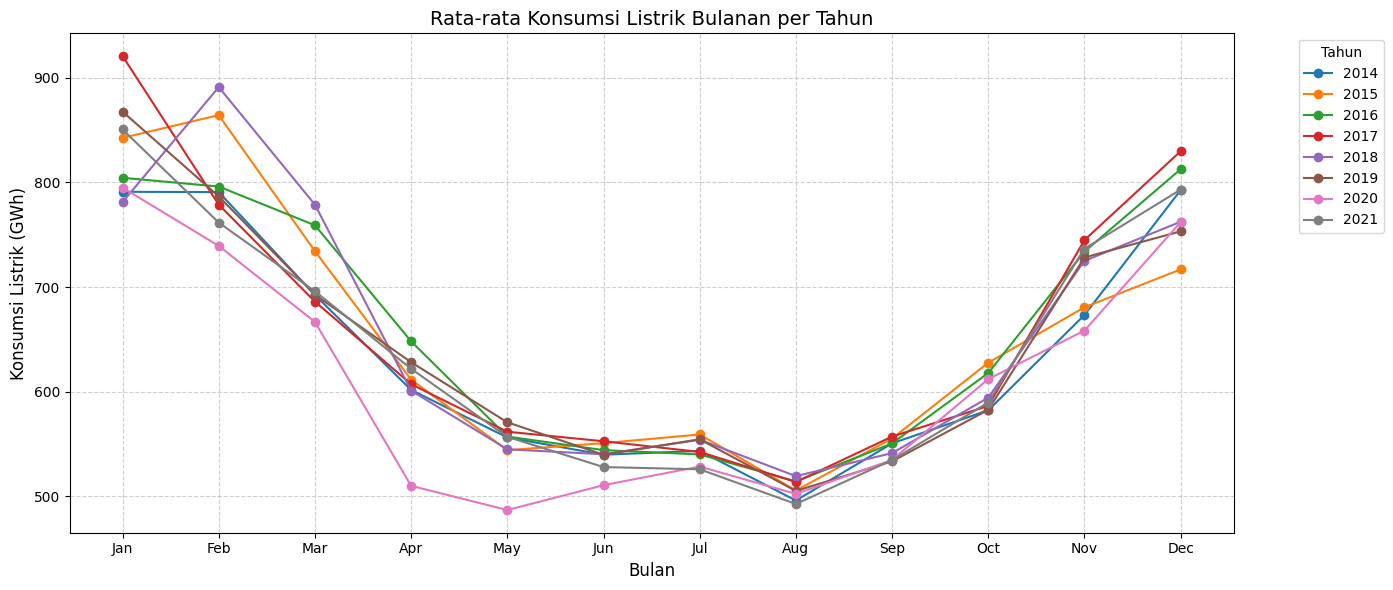

- Gambar 2

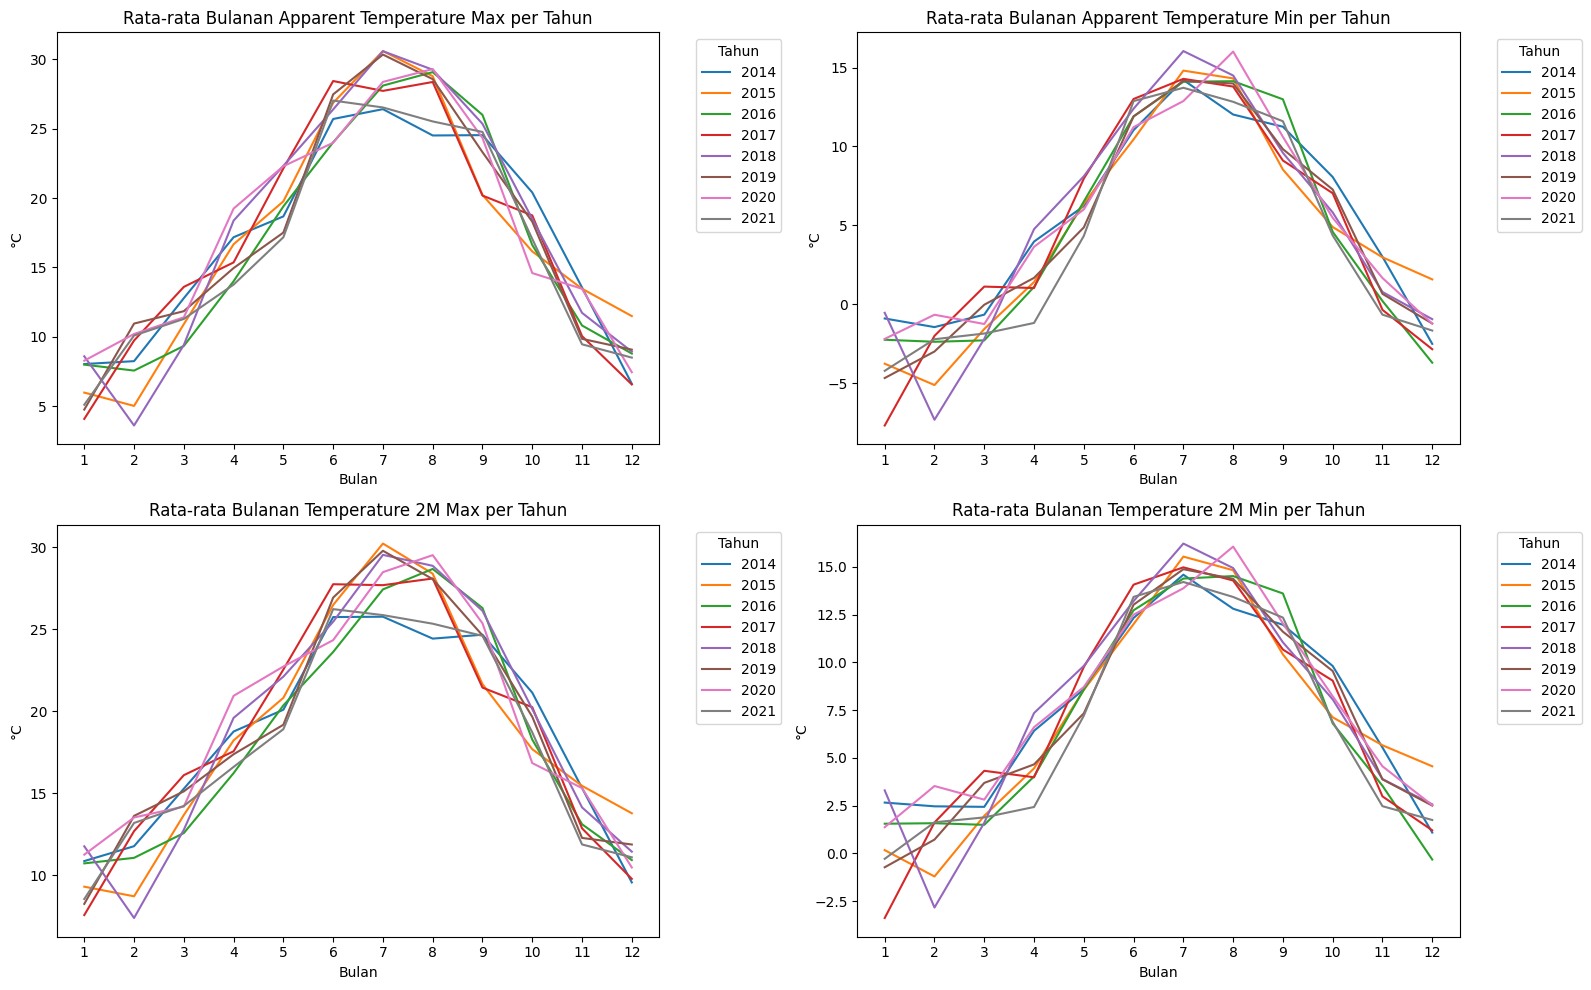

Berdasarkan grafik pada gambar 1 dan gambar 2, dapat disimpulkan bahwa dataset ini kemungkinan besar berasal dari wilayah beriklim empat musim di belahan bumi utara. Hal tersebut ditunjukkan oleh pola konsumsi listrik yang cenderung tinggi pada awal dan akhir tahun, bertepatan dengan musim dingin, serta menurun drastis di pertengahan tahun saat musim panas. Pola tersebut menunjukkan adanya kebutuhan energi yang tinggi untuk pemanasan ruangan selama musim dingin, sedangkan pada musim panas konsumsi listrik relatif rendah, yang mengindikasikan bahwa kebutuhan akan pendinginan tidak sebesar kebutuhan akan pemanasan. Grafik suhu rata-rata bulanan pertahun mendukung indikasi ini, dengan suhu terendah terjadi di awal dan akhir tahun serta suhu tertinggi di pertengahan tahun, konsisten dengan pola iklim empat musim.

Korelasi negatif antara suhu dan konsumsi listrik semakin memperkuat kesimpulan bahwa sumber data ini bukan berasal dari negara tropis, melainkan dari wilayah dengan karakteristik suhu ekstrem di musim dingin. Dalam konteks negara tropis, biasanya konsumsi listrik justru meningkat seiring dengan naiknya suhu karena penggunaan pendingin udara (AC), sedangkan pola yang terlihat di sini berbanding terbalik. Oleh karena itu, kombinasi antara tren musiman konsumsi listrik dan fluktuasi suhu mendukung kesimpulan bahwa data ini berasal dari wilayah dengan iklim empat musim, di mana kebutuhan energi terbesar dipicu oleh pemanasan selama musim dingin.

## 4. Jawaban Pertanyaan Nomor 4
Apakah ada korelasi konsumsi listrik antar cluster/region? Berapa rasio perbandingan rata-rata konsumsi listrik antar cluster, dan bagaimana ini mempengaruhi pendekatan pemodelan Anda?

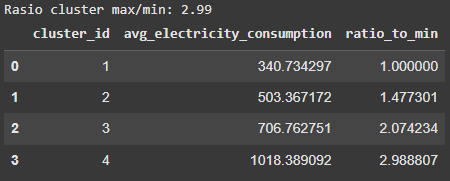

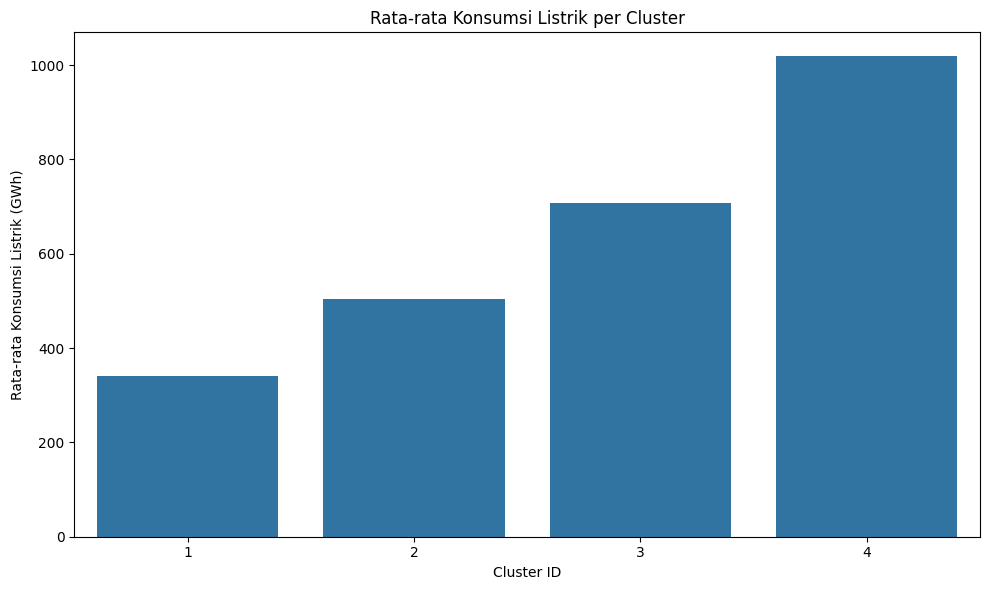

Terdapat korelasi konsumsi listrik antar cluster, namun dengan variasi rata-rata konsumsi yang cukup signifikan. Berdasarkan perhitungan, rata-rata konsumsi listrik untuk masing-masing cluster adalah 340.73 GWh (cluster 1), 503.37 GWh (cluster 2), 706.76 GWh (cluster 3), 1018.39 GWh (cluster 4). Dengan demikian, rasio konsumsi listrik tertinggi terhadap terendah antar cluster adalah 2.99, yang menunjukkan bahwa rata-rata konsumsi listrik di Cluster 4 hampir tiga kali lipat lebih tinggi dibanding Cluster 1.

Perbedaan signifikan antar cluster ini menunjukkan adanya ketidakseimbangan kebutuhan energi di antara wilayah yang direpresentasikan oleh masing-masing cluster. Hal ini bisa dipengaruhi oleh beberapa faktor, seperti kepadatan penduduk, karakteristik ekonomi dan industri, variasi iklim mikro antar wilayah.

Perbedaan rata-rata konsumsi antar cluster yang signifikan membuat saya memilih pendekatan stacking ensemble agar model dapat menangkap pola di cluster dengan karakteristik konsumsi yang berbeda. Kombinasi model boosting (CatBoost, LightGBM, XGBoost), Random Forest, dan Ridge Regression membantu menyeimbangkan prediksi antara pola non-linear dan linear.

Selain itu, saya menggunakan cross-validation dan standarisasi fitur untuk menjaga generalisasi dan stabilitas prediksi di seluruh cluster, sehingga model tidak bias hanya ke cluster dengan konsumsi tinggi. Jika diperlukan, ke depan saya dapat menambahkan penyesuaian weight atau stratified sampling agar model lebih adil antar wilayah.

## 5. Jawaban Pertanyaan Nomor 5
a. Berapa konsumsi listrik rata-rata dari tiap cluster saat suhu minimum di bawah persentil 25 dan durasi sinar matahari di bawah rata-rata? Apa Insight yang bisa didapat dari hal ini?

b. Apakah ada kombinasi cluster dan periode waktu tertentu yang memiliki konsumsi listrik yang dapat dianggap outlier? Jelaskan justifikasi Anda.

Jawaban a

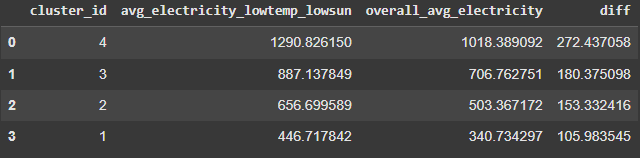

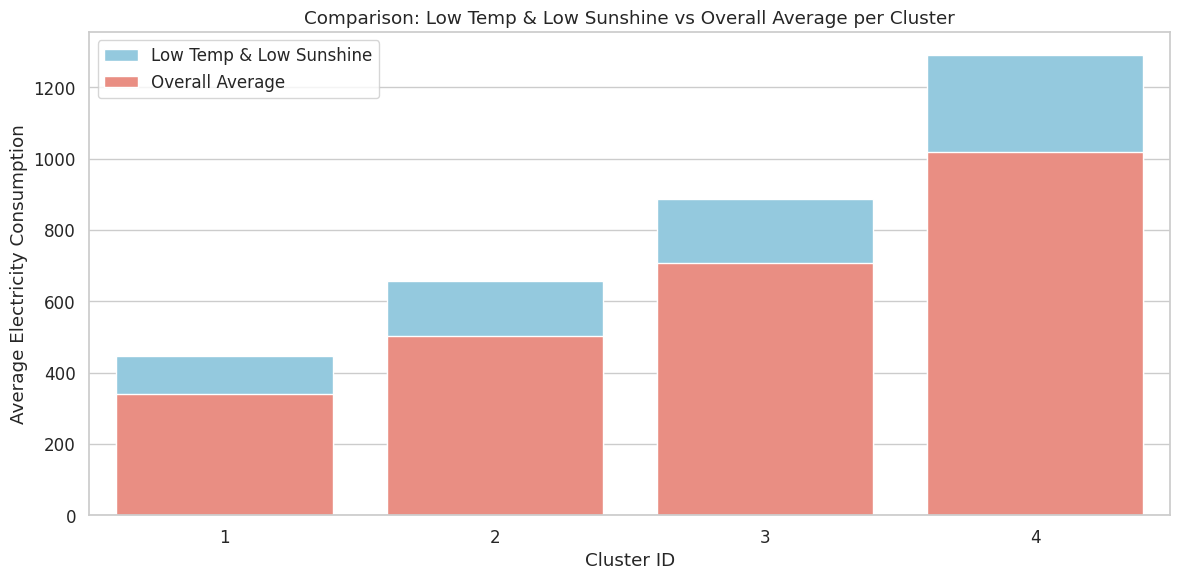


Berdasarkan hasil perhitungan, rata-rata konsumsi listrik pada kondisi suhu minimum di bawah persentil ke-25 dan durasi sinar matahari di bawah rata-rata menunjukkan nilai yang cukup signifikan di setiap cluster. Rata-rata konsumsi listrik masing-masing cluster adalah sebesar 446,72 GWh untuk Cluster 1, 656,70 GWh untuk Cluster 2, 887,14 GWh untuk Cluster 3, dan 1.290,83 GWh untuk Cluster 4. Pola ini konsisten dengan rata-rata konsumsi keseluruhan, di mana cluster dengan konsumsi rata-rata tertinggi tetap mendominasi pada kondisi cuaca dingin dan minim sinar matahari.

Hal ini menunjukkan bahwa faktor suhu rendah dan rendahnya durasi sinar matahari berkontribusi terhadap peningkatan konsumsi listrik, kemungkinan besar karena kebutuhan tambahan untuk pemanas ruangan dan penerangan. Perbedaan rata-rata yang cukup besar, terutama di Cluster 4 dengan selisih lebih dari 272 GWh dibanding rata-rata keseluruhannya, menandakan bahwa wilayah dengan konsumsi tinggi juga lebih sensitif terhadap perubahan kondisi iklim.

Insight ini penting untuk pengelolaan beban listrik, karena memperlihatkan bahwa variabel iklim memiliki pengaruh signifikan dan perlu diperhitungkan dalam perencanaan pasokan energi. Dari sisi pemodelan, hal ini mendukung perlunya memasukkan fitur cuaca, seperti suhu minimum dan durasi sinar matahari, agar prediksi konsumsi listrik dapat lebih akurat dan adaptif terhadap pola musiman maupun kondisi ekstrem.

Jawaban b

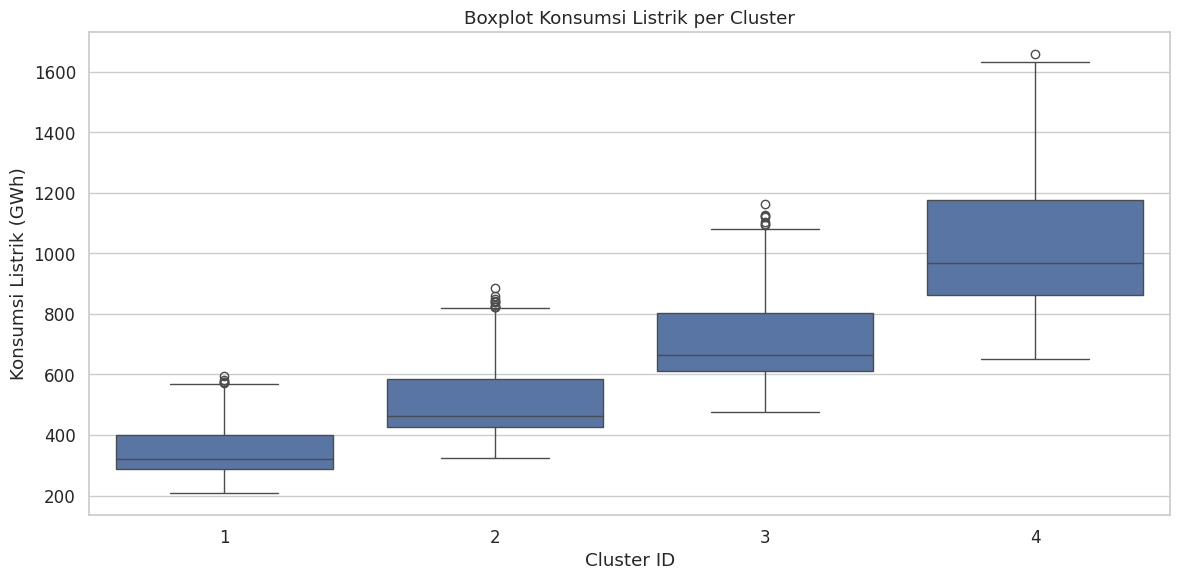

Berdasarkan boxplot konsumsi listrik per cluster, terlihat adanya titik-titik di atas whisker di setiap cluster yang menandakan kehadiran outlier. Secara umum, pola distribusi antar cluster tetap konsisten, yaitu semakin besar cluster, semakin tinggi median dan rentang interkuartil (IQR)-nya.

Namun, pada setiap cluster terdapat nilai-nilai individual yang jauh di atas rentang normal (Q3 + 1.5 IQR). Hal ini terlihat dari beberapa titik di atas garis whisker, khususnya:

- Cluster 1: memiliki beberapa outlier di kisaran ~600 GWh, yang relatif tinggi dibandingkan sebaran normalnya yang umumnya di bawah 500 GWh.
- Cluster 2 dan 3: juga memiliki outlier di ujung atas, menunjukkan periode dengan konsumsi yang jauh lebih tinggi dari pola tipikal cluster tersebut.
- Cluster 4: menunjukkan rentang data yang paling lebar, dengan sebaran outlier di atas ~1600 GWh. Nilai ini cukup ekstrem karena secara median cluster ini berada di kisaran 900–1000 GWh.

Justifikasi:
Outlier ini kemungkinan disebabkan oleh periode tertentu dengan lonjakan permintaan listrik yang tidak biasa, misalnya akibat kondisi cuaca ekstrem, lonjakan aktivitas industri musiman, atau kejadian luar biasa lain (misalnya hari libur panjang dengan peningkatan penggunaan listrik rumah tangga).

Dari sudut pandang analisis data, nilai-nilai ini wajar dianggap outlier secara statistik karena melewati batas whisker yang dihitung dari IQR. Namun, dalam konteks perencanaan beban listrik, outlier semacam ini justru penting dianalisis lebih lanjut, karena bisa menunjukkan beban puncak yang perlu diantisipasi. Oleh karena itu, daripada dihapus, outlier ini sebaiknya dipelajari sebagai skenario ekstrem untuk mendukung kebijakan manajemen daya yang lebih robust.

## 6. Jawaban Pertanyaan Nomor 6
Apakah ada pasangan variabel cuaca yang berkorelasi tinggi? Apakah ada efek multicollinearity yang perlu diatasi dalam modeling?

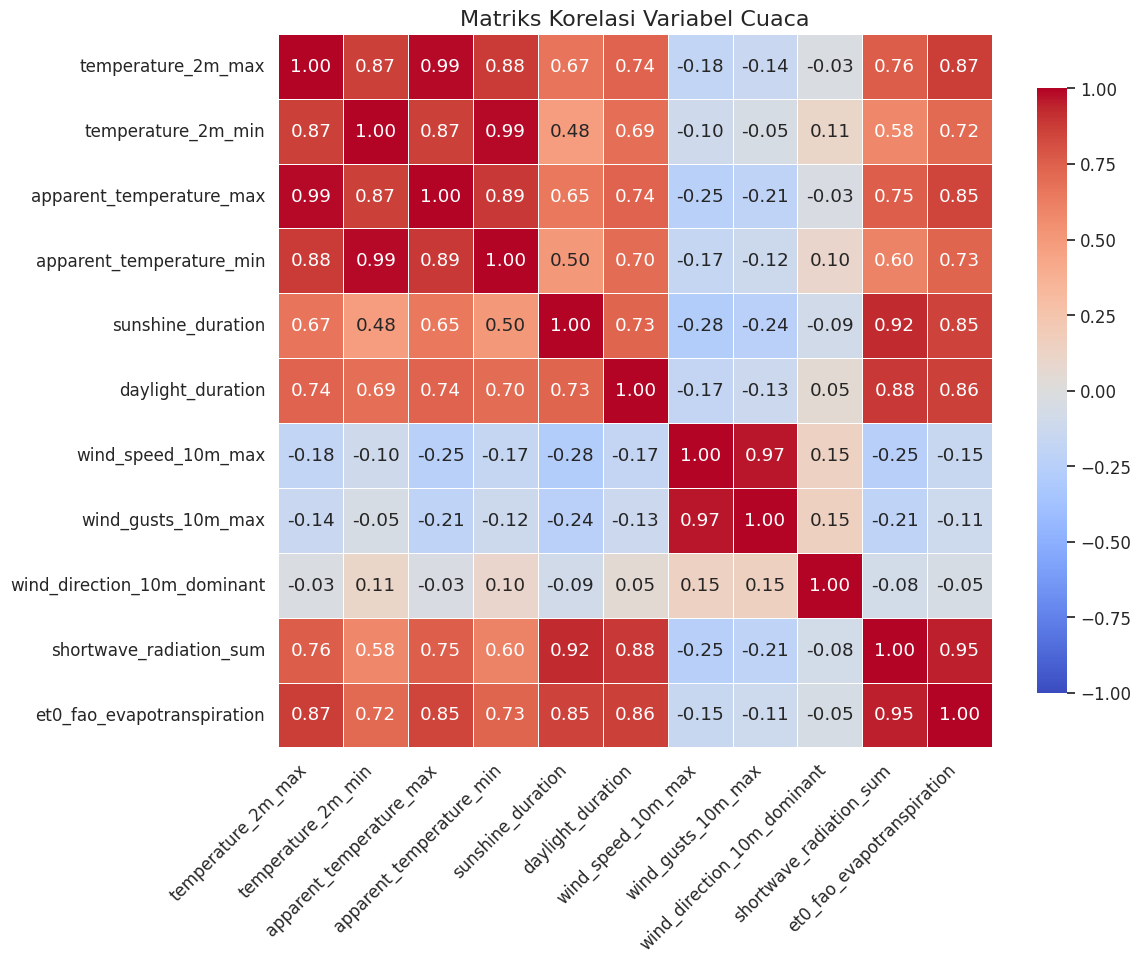

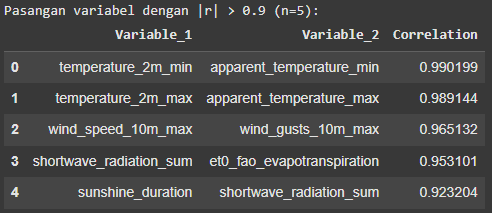

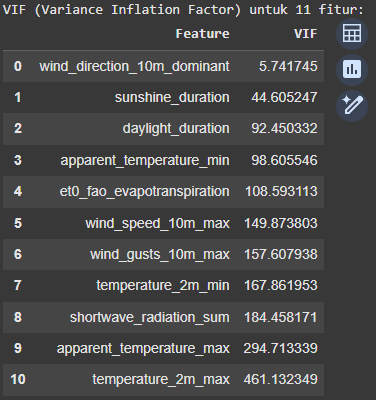

Berdasarkan hasil analisis matriks korelasi antar variabel cuaca pada gambar 4, ditemukan beberapa pasangan variabel yang memiliki korelasi sangat tinggi, yaitu di atas 0,9. Beberapa contoh di antaranya adalah temperature_2m_max dengan apparent_temperature_max (r = 0,99), temperature_2m_min dengan apparent_temperature_min (r = 0,99), wind_speed_10m_max dengan wind_gusts_10m_max (r = 0,97), serta sunshine_duration dengan shortwave_radiation_sum (r = 0,92). Selain itu, shortwave_radiation_sum juga memiliki korelasi yang sangat tinggi dengan et0_fao_evapotranspiration (r = 0,95). Korelasi yang sangat tinggi antar variabel ini menunjukkan adanya redundansi informasi di dalam dataset cuaca.

Kondisi multikolinearitas yang kuat ini juga semakin diperkuat dengan hasil perhitungan Variance Inflation Factor (VIF). Beberapa variabel memiliki nilai VIF yang sangat tinggi, seperti temperature_2m_max (VIF = 461,13), apparent_temperature_max (VIF = 294,71), shortwave_radiation_sum (VIF = 184,46), dan et0_fao_evapotranspiration (VIF = 108,59). Nilai VIF yang melebihi angka 10 sudah menunjukkan indikasi multikolinearitas yang signifikan, dan dalam kasus ini bahkan terdapat beberapa fitur yang memiliki VIF lebih dari 100, sehingga dipastikan multikolinearitas terjadi secara ekstrem.

Dampak dari multikolinearitas ini adalah adanya potensi distorsi dalam interpretasi model regresi serta ketidakstabilan koefisien regresi yang dihasilkan. Oleh karena itu, untuk mengatasi permasalahan ini, perlu dilakukan langkah mitigasi. Salah satu pendekatan yang dapat diterapkan adalah dengan melakukan seleksi fitur, yaitu mempertahankan satu fitur yang paling representatif dari kelompok variabel yang saling berkorelasi tinggi, dan menghapus sisanya

## 7. Jawaban Pertanyaan Nomor 7
Fitur baru apa saja yang Anda buat melalui proses feature engineering? Jelaskan bagaimana fitur tersebut meningkatkan pemahaman model terhadap pola konsumsi listrik!

Dalam proses feature engineering yang saya lakukan melalui fungsi create_features, saya membuat berbagai kelompok fitur baru yang bertujuan untuk membantu model memahami pola konsumsi listrik secara lebih mendalam. Pertama, saya menambahkan fitur temporal seperti year, month, day, dayofweek, dayofyear, quarter, is_weekend, is_month_start, dan is_month_end. Fitur-fitur ini saya gunakan agar model dapat menangkap pola musiman, tren mingguan, serta pengaruh hari kerja atau akhir pekan terhadap variasi konsumsi listrik.

Selain itu, saya juga membuat encoding siklikal pada bulan, hari, hari dalam seminggu, dan hari dalam tahun (misalnya month_sin, month_cos) supaya model bisa mengenali pola berulang dengan lebih mulus tanpa terjebak pada perbedaan numerik di awal dan akhir siklus.

Selanjutnya, saya membangun fitur suhu turunan seperti temp_range, temp_mean, apparent_temp_range, heating_degree_days, cooling_degree_days hingga polynomial temp_mean_squared dan temp_mean_cubed. Fitur-fitur ini saya buat karena saya menyadari bahwa variasi suhu, baik aktual maupun suhu persepsi, berpengaruh langsung pada kebutuhan pemanasan atau pendinginan, sehingga berhubungan erat dengan konsumsi listrik. Saya juga membagi suhu ke dalam beberapa zona suhu (seperti extreme_cold, cold, mild, warm, hot) agar model dapat membedakan perilaku konsumsi pada kondisi cuaca ekstrem.

Untuk mendeteksi anomali musiman, saya menambahkan temp_deviation_from_seasonal dan temp_seasonal_anomaly agar model bisa melihat perbedaan suhu harian terhadap suhu rata-rata musimannya. Dari sisi cuaca lain, saya juga membuat fitur angin (wind_range, wind_intensity, wind_direction_sin, wind_direction_cos) untuk menangkap pengaruh angin terhadap hilangnya panas atau pendinginan bangunan. Beberapa fitur interaksi, misalnya temp_wind_interaction atau temp_solar_interaction, saya buat agar model bisa memahami efek gabungan antara suhu, angin, dan radiasi matahari.

Kemudian, saya juga menambahkan fitur solar seperti sunshine_ratio, radiation_per_sunshine, dan cloud_cover_proxy sebagai proksi untuk mendeteksi seberapa besar radiasi matahari yang masuk dan memengaruhi suhu ruangan. Untuk menangkap sinyal historis, saya membuat fitur rata-rata bergerak, tren, dan volatilitas suhu serta radiasi (cluster_temp_ma_7, cluster_temp_trend_7, temp_volatility_7), agar model punya konteks pola jangka pendek di setiap cluster. Saya juga menambahkan dummy cluster_id dan beberapa fitur khusus cluster seperti {cid}_temp atau {cid}_heating agar model bisa membedakan karakteristik konsumsi di tiap cluster.

Terakhir, saya membuat fitur kalender dan stres cuaca seperti working_day_intensity, is_near_new_year, extreme_heating_scenario, weather_stress_index, comfort_deviation hingga seasonal_energy_pressure. Fitur-fitur ini saya buat untuk menangkap momen-momen khusus yang secara historis sering memengaruhi lonjakan atau penurunan konsumsi listrik, misalnya kondisi cuaca ekstrem atau hari libur panjang.

Dengan semua fitur ini, saya berharap model dapat menangkap hubungan yang lebih kompleks antara pola waktu, cuaca, perilaku manusia, serta karakteristik lokal, sehingga prediksi konsumsi listrik bisa lebih akurat dan realistis dibanding hanya mengandalkan fitur mentah bawaan dari dataset awal.

## 8. Jawaban Pertanyaan Nomor 8
Jelaskan model yang Anda gunakan dalam memprediksi konsumsi listrik! Mengapa Anda memilih model tersebut dibanding alternatif lain?

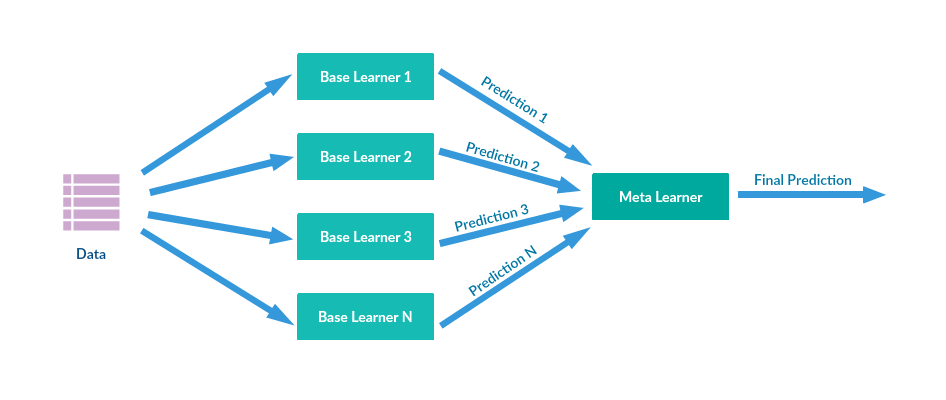

Dalam memprediksi konsumsi listrik, saya menggunakan pendekatan stacking ensemble, yaitu menggabungkan beberapa model dasar (base models) dan satu meta model di lapisan akhir. Model dasar yang saya gunakan adalah CatBoost, LightGBM, XGBoost, Random Forest, dan Ridge Regression, sedangkan meta model-nya adalah Ridge Regression.

Saya memilih model stacking karena konsumsi listrik memiliki pola yang kompleks, melibatkan hubungan non-linear dan variasi antar cluster yang signifikan. Model boosting seperti CatBoost, LightGBM, dan XGBoost sangat baik dalam menangkap pola non-linear dan interaksi fitur, sementara Random Forest menambah keragaman model dengan pendekatan bagging, dan Ridge Regression menjaga kestabilan prediksi pada pola linear.

Dengan cara ini, kelemahan satu model dapat dikompensasi oleh model lain. Hasil prediksi setiap model dasar digabungkan (out-of-fold prediction) dan dilatih ulang dengan meta model Ridge untuk menghasilkan prediksi akhir yang lebih akurat.

Alternatif lain seperti hanya memakai satu model boosting saja saya anggap kurang optimal karena tidak memanfaatkan kelebihan ensembling dalam mengurangi bias dan variance secara bersamaan. Selain itu, dengan cross-validation, saya memastikan bahwa model tidak overfit pada pola cluster tertentu.

Pendekatan stacking ini cocok untuk data dengan distribusi target yang tidak seimbang antar cluster, seperti konsumsi listrik, sehingga prediksi dapat lebih seimbang, generalisasi lebih kuat, dan performa keseluruhan lebih stabil.

## 9. Jawaban Pertanyaan Nomor 9
Menurut Anda, apakah metrik penilaian RMSE tepat untuk kasus ini? Jika tidak, metrik apa yang lebih tepat? Elaborasikan jawaban Anda!

RMSE (Root Mean Squared Error) sering digunakan untuk mengukur akurasi model regresi karena sensitif terhadap error yang besar artinya, RMSE memberi penalti lebih besar jika prediksi sangat jauh dari nilai sebenarnya. Hal ini berguna jika deviasi ekstrem memang perlu dihindari, misalnya untuk menjaga keandalan pasokan listrik.

Namun, untuk kasus prediksi konsumsi listrik di beberapa cluster dengan rata-rata konsumsi yang berbeda signifikan, penggunaan RMSE saja bisa kurang tepat. RMSE cenderung dipengaruhi oleh cluster dengan konsumsi terbesar (seperti Cluster 4), sehingga kesalahan pada cluster kecil (seperti Cluster 1) tidak terlalu “terlihat” di nilai akhir RMSE. Akibatnya, model bisa cenderung overfit pada cluster dominan dan kurang optimal pada cluster dengan volume lebih kecil.

Untuk membuat evaluasi lebih adil dan komprehensif, sebaiknya RMSE dilengkapi dengan metrik lain, seperti:

- MAE (Mean Absolute Error): Menghitung rata-rata selisih absolut, lebih tahan terhadap outlier dan mudah diinterpretasi.

- MAPE (Mean Absolute Percentage Error): Mengukur error dalam persentase, sehingga cocok untuk membandingkan performa di cluster dengan skala konsumsi berbeda.

- RMSE per cluster: Nilai RMSE dihitung per cluster, lalu dirata-rata, sehingga kinerja di cluster kecil tetap diperhitungkan.

Dengan kombinasi ini, kita bisa memastikan model tidak hanya akurat secara total, tetapi juga adil dan stabil di seluruh cluster. Jadi, RMSE tetap berguna, tetapi tidak boleh digunakan sendiri, metrik tambahan seperti MAE, MAPE, atau evaluasi cluster-wise lebih relevan untuk mendukung keputusan yang lebih tepat.

## 10. Jawaban Pertanyaan Nomor 10
Jika Anda boleh mengambil data eksternal, data tentang apa yang akan Anda ambil untuk meningkatkan akurasi prediksi konsumsi listrik? Jelaskan alasan pemilihannya dan bagaimana data itu dapat diintegrasikan.

Untuk meningkatkan akurasi prediksi konsumsi listrik, saya akan menambahkan data eksternal terkait aktivitas ekonomi, kependudukan, dan kejadian khusus. Beberapa contoh data yang relevan adalah:

1. Data Sosial-Ekonomi

  Misalnya, PDB regional (Gross Regional Domestic Product), tingkat produksi industri, atau volume konsumsi energi di sektor industri dan komersial. Konsumsi listrik umumnya sangat dipengaruhi oleh aktivitas ekonomi; ketika produksi industri naik, beban listrik meningkat signifikan. Data ini bisa diambil dari Badan Pusat Statistik atau sumber open data pemerintah.

2. Data Kepadatan dan Mobilitas Penduduk

  Jumlah penduduk atau mobilitas (misalnya data Google Mobility atau data jumlah perjalanan) berpengaruh pada konsumsi listrik sektor rumah tangga dan komersial. Pada periode liburan panjang atau mudik, konsumsi listrik di satu cluster bisa menurun, sementara di cluster tujuan mudik bisa meningkat.

3. Kalender Hari Libur Nasional dan Event Besar

  Kalender resmi hari libur nasional, cuti bersama, atau event besar seperti Idul Fitri, Natal, Tahun Baru, dan libur sekolah sangat memengaruhi pola konsumsi listrik. Data ini mudah diintegrasikan sebagai fitur binary flag (misalnya is_holiday atau is_event).

4. Harga Listrik dan Kebijakan Energi

  Data tarif listrik atau kebijakan subsidi juga dapat berpengaruh. Jika terjadi penyesuaian tarif, pola konsumsi bisa berubah. Fitur ini bisa diintegrasikan sebagai time-based feature yang berubah per periode.

Data-data ini dapat di-merge ke dataset utama berdasarkan kolom waktu (date) dan cluster/region (cluster_id). Setelah itu, informasi tersebut dapat diturunkan menjadi fitur numerik atau kategorik, misalnya:

- Fitur lagging atau rolling mean untuk data ekonomi (agar tren dapat terbaca).

- Fitur dummy untuk hari libur atau event khusus.

- Fitur interaksi, misalnya interaksi antara cuaca ekstrem dan event libur panjang.

Dengan penambahan data eksternal ini, model dapat menangkap pola permintaan listrik yang lebih realistis karena selain faktor cuaca, variabel manusia dan ekonomi juga turut dipertimbangkan. Hal ini penting terutama ketika prediksi dilakukan lintas cluster dengan karakteristik penduduk dan ekonomi yang beragam.

## Daftar Pusaka

[1]	R. Banik, P. Das, S. Ray, and A. Biswas, “Prediction of electrical energy consumption based on machine learning technique,” Electr. Eng., vol. 103, no. 2, pp. 909–920, 2021, doi: 10.1007/s00202-020-01126-z.

[2]	R. Indrawan, “Apa Keuntungan Teknologi Smart Grid Dalam Operasi Sistem Tenaga Listrik » Berita energi & Minerba Hari Ini - RuangEnergi.com.” Accessed: Jun. 15, 2025. [Online]. Available: https://www.ruangenergi.com/apa-keuntungan-teknologi-smart-grid-dalam-operasi-sistem-tenaga-listrik/

[3]	R. Primadya, “CEO Climate Talks: PLN Siap Dukung Pemerintah Capai 75% Energi Terbarukan hingga Tahun 2040 - PT PLN (Persero).” Accessed: Jun. 15, 2025. [Online]. Available: https://web.pln.co.id/cms/media/siaran-pers/2024/11/ceo-climate-talks-pln-siap-dukung-pemerintah-capai-75-energi-terbarukan-hingga-tahun-2040/

[4]	F. UNAIR, “Mengenal Smart Grid dan Berbagai Manfaatnya Untuk Lingkungan dan Ekonomi - Fakultas Teknologi Maju dan Multidisiplin | Universitas Airlangga.” Accessed: Jun. 15, 2025. [Online]. Available: https://ftmm.unair.ac.id/mengenal-smart-grid-dan-berbagai-manfaatnya-untuk-lingkungan-dan-ekonomi/

[5]	Samudin Harsanto, “Statistik Listrik ‘Electric Statistic’ 2013-2018,” pp. 1–67, 2024, Accessed: Jun. 15, 2025. [Online]. Available: https://www.bps.go.id/id/publication/2024/12/20/e7ed55c8a2ccc05c87d93066/statistik-listrik-2019-2023.html